## Data Preprocessing & Network Setup

In [3]:
# Installing necessary libraries 
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install networkx
# !pip install powerlaw
# !pip install graphistry
# !pip install cpi
# !pip install nltk
# !pip install scipy

In [122]:
# Importing necessary libraries
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import networkx as nx
import powerlaw
import seaborn as sns
import graphistry
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from scipy import stats
from networkx.algorithms import community
import cpi
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import chain
from community import community_louvain

nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/michalisdikaiopoulos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/michalisdikaiopoulos/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Load data & initialize graph nodes

The following code block loads the Boxofficemojo dataset, removes movies where there is no worldwide box office data, convert runtime to integers, converts release date to "xx-xx-xxxx" format and initializes the graph nodes  

In [5]:
movies = pd.read_csv(r'data\Kaggle\Mojo_budget_update.csv\Mojo_budget_update.csv')
# remove a column mpaa
movies = movies.drop(columns=['mpaa'])
# remove rows with nan in worldwide and in budget
movies = movies.dropna(subset=["worldwide"])
# movies = movies.dropna(subset=["budget"])
# fill nan with unknown
movies = movies.fillna("UNKNOWN",)
# number of nan in each column 
# {'mpaa': 161, 'release_date': 1, 'distributor': 15, 'writer': 9, 'producer': 13, 'composer': 105, 'cinematographer': 114, 
# 'main_actor_4': 3, 'domestic': 19, 'international': 410, 'worldwide': 7, 'genre_2': 281, 'genre_3': 1022, 'genre_4': 2120}

#Make a graph
movie_graph = nx.Graph()
movie_graph.add_nodes_from(movies['title'])

# reformat the date
def getDate(year,date):
    dict_months = {'January':"1", 'February':"2", 'March':"3", 'April':"4", 'May':"5", 'June':"6", 'July':"7", 'August':"8", 'September':"9", 'October':"10", 'November':"11", 'December':"12"}
    try:
        date = date.split()
    except:
        date = ['January','1']
    year = str(year)
    date = str(date[1]) + '-' + dict_months[date[0]] + '-' + year
    return date

# reformat the run time
def getRunTime(run_time):
    try:
        run_time = run_time.split()
        run_time = int(run_time[0]) * 60 + int(run_time[2])
    except:
        run_time = "UNKNOWN"
    return run_time

# add attributes to the nodes#mpaa is after the release year
for node in movie_graph.nodes:
    row = movies.loc[movies['title'] == node]
    movie_id, _,release_year,_,release_date, run_time, distributor, director, writer, producer, composer, cinematographer, \
    main_actor_1, main_actor_2, main_actor_3, main_actor_4, budget, domestic, international, worldwide, \
    genre_1, genre_2, genre_3, genre_4, link = row.iloc[0, :].values

    release_date = getDate(release_year, release_date)
    run_time = getRunTime(run_time)
    actors = [main_actor_1, main_actor_2, main_actor_3, main_actor_4]
    genres = [genre_1, genre_2, genre_3, genre_4]
    
    movie_graph.nodes[node]['movie_id'] = movie_id
    movie_graph.nodes[node]['release_year'] = release_year
    movie_graph.nodes[node]['release_date'] = release_date
    movie_graph.nodes[node]['run_time'] = run_time
    movie_graph.nodes[node]['distributor'] = distributor
    movie_graph.nodes[node]['director'] = director
    movie_graph.nodes[node]['writer'] = writer
    movie_graph.nodes[node]['producer'] = producer
    movie_graph.nodes[node]['composer'] = composer
    movie_graph.nodes[node]['cinematographer'] = cinematographer
    movie_graph.nodes[node]['actors'] = actors
    movie_graph.nodes[node]['budget'] = budget
    movie_graph.nodes[node]['domestic'] = domestic
    movie_graph.nodes[node]['international'] = international
    movie_graph.nodes[node]['worldwide'] = worldwide
    movie_graph.nodes[node]['genres'] = genres
    movie_graph.nodes[node]['link'] = link


In [6]:
# Print information about the movie network

print("Number of nodes", len(movie_graph.nodes)) 
print("Number of unique distributor", len(movies["distributor"].unique()))
# print("precentag of movies per distributor" , movies["distributor"].value_counts())
print(f"Budget Stats \n mean is {round(movies["budget"].mean())}, midian is {movies["budget"].median()}, standard deviation budget is { round(movies["budget"].std())}")
print(f"worldwide Stats \n mean is {round(movies["worldwide"].mean())}, midian is {movies['worldwide'].median()}, standard deviation worldwide is { round(movies['worldwide'].std())}")
print("Number of unique genres", len(movies["genre_1"].unique()))
print("Number of unique actors", len((movies["main_actor_1"]+movies["main_actor_2"]+movies["main_actor_3"]+movies["main_actor_4"]).unique()))
print(f"Number of unique directors {len(movies['director'].unique())} writers {len(movies['writer'].unique())} and producers {len(movies['producer'].unique())} and composers {len(movies['composer'].unique())} and cinematographers {len(movies['cinematographer'].unique())}")
print(f"Earnings Stats \n mean is {round(movies['worldwide'].mean())-round(movies['budget'].mean())}, midian is {movies['worldwide'].median()-movies['budget'].median()}")
print("biggest Winner is ", movies.loc[(movies['worldwide']-movies['budget']).idxmax()]['title'])
print("biggest Loser is ", movies.loc[(movies['worldwide']-movies['budget']).idxmin()]['title'])

Number of nodes 3208
Number of unique distributor 197
Budget Stats 
 mean is 46308759, midian is 30000000.0, standard deviation budget is 47097816
worldwide Stats 
 mean is 139312154, midian is 62251587.5, standard deviation worldwide is 216210703
Number of unique genres 15
Number of unique actors 3212
Number of unique directors 1520 writers 2103 and producers 1539 and composers 792 and cinematographers 854
Earnings Stats 
 mean is 93003395, midian is 32251587.5
biggest Winner is  Avatar
biggest Loser is  Mars Needs Moms


The following code block does:
* Reads the Rotten Tomatoes reviews dataset
* keeps the movie id, reviewid, and review text
* drop rows that holds no review text
* Reads the Rotten Tomatoes movies dataset (where it  holds information about the movies)
* Joins the 2 data sets into a `merged_reviews` data sets that now holds id, reviewId, reviewText and movie title

In [7]:
reviews = pd.read_csv(r'data\Kaggle\Rotten_Tomatoes\rotten_tomatoes_movie_reviews.csv')
reviews_head = reviews.head()
reviews=reviews[["id","reviewId","reviewText"]]
reviews = reviews.dropna(subset=["reviewText"])
RT_movies = pd.read_csv(r'data\Kaggle\Rotten_Tomatoes\rotten_tomatoes_movies.csv')
RT_movies=RT_movies[["id","title","tomatoMeter"]]
merged_reviews = pd.merge(RT_movies, reviews, on='id')
merged_reviews = pd.merge(merged_reviews, movies[['title']], left_on='title', right_on='title')

In [8]:
# Print information about the reviews

print("number of movies with reviews", len(merged_reviews['title'].unique()))
print("number of reviews", len(merged_reviews['reviewId'].unique()))
print("number of reviews per movie", merged_reviews['title'].value_counts(ascending=False))
print(f"mean number of reviews per movie {merged_reviews['title'].value_counts().mean()} median {merged_reviews['title'].value_counts().median()}")
print("number of movies with more than 50 reviews", len(merged_reviews['title'].value_counts()[merged_reviews['title'].value_counts()>50]))
print(f"The mean length of reviews is {merged_reviews['reviewText'].apply(len).mean()} and the median is {merged_reviews['reviewText'].apply(len).median()}")
print(f"The mean number of words in reviews is {merged_reviews['reviewText'].apply(lambda x: len(x.split())).mean()} and the median is {merged_reviews['reviewText'].apply(lambda x: len(x.split())).median()}")

number of movies with reviews 2932
number of reviews 413562
number of reviews per movie title
Parasite                             1921
Beauty and the Beast                 1168
The Lion King                        1122
Godzilla                             1084
Little Women                         1038
                                     ... 
Search and Destroy                      1
Beat the Drum                           1
Alone Yet Not Alone                     1
The Last Time I Committed Suicide       1
Midget Zombie Takeover                  1
Name: count, Length: 2932, dtype: int64
mean number of reviews per movie 146.55388813096863 median 130.0
number of movies with more than 50 reviews 2448
The mean length of reviews is 127.99440301980935 and the median is 127.0
The mean number of words in reviews is 21.466581024724455 and the median is 21.0


### Add the reviews of the movies in nodes

In [9]:
dicReviews = {}
for index, row in merged_reviews.iterrows():
    if row['title'] in movie_graph.nodes:
        if row['title'] not in dicReviews:
            dicReviews[row['title']] = []
        dicReviews[row['title']].append(row['reviewText'])
print("Number of movies with reviews", len(dicReviews))
print("total number of reviews", len([j for i in dicReviews.values() for j in i]))

for node in movie_graph.nodes:
    if node in dicReviews:
        movie_graph.nodes[node]['reviews'] = dicReviews[node]
        movie_graph.nodes[node]['tomatoMeter'] =merged_reviews.loc[merged_reviews['title'] == node]['tomatoMeter'].values[0] 

Number of movies with reviews 2932
total number of reviews 429696


In [11]:
print("Number of nodes", len(movie_graph.nodes)) 

Number of nodes 3208


### Remove movies with no reviews

In [12]:
nodes_to_remove = []

# Find nodes without the "reviews" attributes
for node in movie_graph.nodes:
    if movie_graph.nodes[node].get("reviews") is None:
        nodes_to_remove.append(node)

# Remove those nodes from the graph
movie_graph.remove_nodes_from(nodes_to_remove)

In [13]:
print("Number of nodes", len(movie_graph.nodes)) 

Number of nodes 2932


### Adjust the monetary values for inflation

In [14]:
##  Values to adjust : budget, domestic, international, worldwide 
for node in movie_graph.nodes:
    movie_graph.nodes[node]['budget'] = cpi.inflate(int(movie_graph.nodes[node]['budget']), movie_graph.nodes[node]['release_year'])
    if movie_graph.nodes[node]['domestic'] != "UNKNOWN":
        movie_graph.nodes[node]['domestic'] = cpi.inflate(int(movie_graph.nodes[node]['domestic']), movie_graph.nodes[node]['release_year'])
    if movie_graph.nodes[node]['international'] != "UNKNOWN":
        movie_graph.nodes[node]['international'] = cpi.inflate(int(movie_graph.nodes[node]['international']), movie_graph.nodes[node]['release_year'])
    movie_graph.nodes[node]['profit'] = movie_graph.nodes[node]['worldwide'] - movie_graph.nodes[node]['budget']

### Calculate the sentiment of nodes

In [15]:
# Create an instance of the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# get sentiment for each review in each node
for node in movie_graph.nodes:
    reviews = movie_graph.nodes[node]['reviews']

    sentiments_per_review = [analyzer.polarity_scores(review) for review in reviews]
    
    # movie's sentiment based on all reviews (mean compound score)          
    compound_sentiments = [sentiment_scores["compound"] for sentiment_scores in sentiments_per_review]
    movie_sentiment = np.mean(compound_sentiments) if compound_sentiments else 0.0
    
    # Assign the aggregated sentiment to the node
    movie_graph.nodes[node]['mean_compound_sentiment'] = movie_sentiment
    movie_graph.nodes[node]['sentiments_per_review'] = sentiments_per_review

In [16]:
movie_graph.nodes["Die Hard 2"]

{'movie_id': 'tt0099423',
 'release_year': 1990,
 'release_date': '6-7-1990',
 'run_time': 124,
 'distributor': 'Twentieth Century Fox',
 'director': 'Renny Harlin',
 'writer': 'Walter Wager',
 'producer': 'Charles Gordon',
 'composer': 'Michael Kamen',
 'cinematographer': 'Oliver Wood',
 'actors': ['Bruce Willis',
  'William Atherton',
  'Bonnie Bedelia',
  'Reginald VelJohnson'],
 'budget': 163191583.77964807,
 'domestic': 274024189.9984239,
 'international': 286066654.1482173,
 'worldwide': 240247433.0,
 'genres': ['Action', 'Thriller', 'UNKNOWN', 'UNKNOWN'],
 'link': 'https://www.boxofficemojo.com/title/tt0099423/credits/',
 'reviews': ['Plays it very safe with the plot by copying a lot of what made the first work but sadly the villains of the piece are far&#44; far less interesting&#46; It does have some fun scenes and Bruce Willis is still on fine form so still worth a watch though&#46;&#46;&#46;',
  'Die Hard 2 is ubiquitous and sensationally entertaining. [Full review in Spanis

In [18]:
for node in list(movie_graph.nodes)[:5]:
    print(f"- Movie : {node}")
    print(f"- Mean Compound Sentiment : {movie_graph.nodes[node]["mean_compound_sentiment"]}")
    print(f"- Rotten Tomatoes score : {movie_graph.nodes[node]["tomatoMeter"]}", "\n")


- Movie : Back to the Future Part III
- Mean Compound Sentiment : 0.4589757575757576
- Rotten Tomatoes score : 80.0 

- Movie : The Bonfire of the Vanities
- Mean Compound Sentiment : -0.07092222222222222
- Rotten Tomatoes score : 15.0 

- Movie : Dick Tracy
- Mean Compound Sentiment : 0.1416142857142857
- Rotten Tomatoes score : nan 

- Movie : Die Hard 2
- Mean Compound Sentiment : 0.10247884615384614
- Rotten Tomatoes score : 70.0 

- Movie : Flight of the Intruder
- Mean Compound Sentiment : 0.02735
- Rotten Tomatoes score : 25.0 



#### Bayesian Adjustment of movie sentiments

In this analysis, we apply **Bayesian adjustment** to refine the sentiment of each movie based on its review count and the global sentiment of all movies in the network.

The basic idea is to adjust each movie's sentiment by **shrinking** it toward the **global sentiment (Prior)**, especially for movies with fewer reviews, which may have more uncertainty in their sentiment values. This way, movies with fewer reviews are "regularized" and their sentiment is adjusted closer to the overall trend of the movie network.

The formula for Bayesian adjustment is:

$$
\text{Adjusted Sentiment}_i = \frac{(n_i \cdot \text{mean\_sentiment}_i) + (m \cdot \text{Global Sentiment})}{n_i + m}
$$

Where:
- \( $ n_i $ \) is the number of reviews for movie \( $ i $ \),
- \( $ \text{mean\_sentiment}\_i $ \) is the mean sentiment of movie \( $ i $ \),
- \( $ m $ \) is a tuning parameter that controls the influence of the **Global Sentiment** (Prior),
- \( $ \text{Global Sentiment} $ \) is the average sentiment of all movies in the network.

This adjustment helps to reduce the influence of movies with fewer reviews and ensures that the global sentiment remains consistent even when a movie has only a few data points.


##### PRIOR (Global sentiment) based on the unadjusted sentiments


In [20]:
# Calculate the Global Sentiment (Prior) as the mean of the mean_compound_sentiment values
def calculate_global_sentiment(G, adjusted=False):
    total_sentiment = 0
    num_movies = len(G.nodes)
    
    sentiment_type = "adjusted_sentiment" if adjusted else "mean_compound_sentiment" 
    
    for node in G.nodes:
        total_sentiment += G.nodes[node][sentiment_type]
    
    return total_sentiment / num_movies

# Calculate the initial Global Sentiment (Prior)
global_sentiment = calculate_global_sentiment(movie_graph)
print(global_sentiment)

0.17876725900853307


##### Adjustment of the sentiments

In [21]:
# Apply Bayesian Adjustment for each movie using the Prior
def apply_bayesian_adjustment(G, global_sentiment, m=5):
    for node in G.nodes:
        num_reviews = len(G.nodes[node]["reviews"])  
        mean_sentiment = G.nodes[node]["mean_compound_sentiment"]
        
        # Apply Bayesian adjustment
        adjusted_sentiment = (num_reviews * mean_sentiment + m * global_sentiment) / (num_reviews + m)
        
        # Update the node with the adjusted sentiment
        G.nodes[node]["adjusted_sentiment"] = adjusted_sentiment


apply_bayesian_adjustment(movie_graph, global_sentiment)

##### PRIOR (Global sentiment) after the adjustment of sentiments

In [22]:
# Recalculate the Global Sentiment after adjustment
adjusted_global_sentiment = calculate_global_sentiment(movie_graph, adjusted=True)

##### BAYESIAN ADJUSTMENT OVERVIEW

In [25]:
print("GLOBAL SENTIMENT (PRIOR):")
print(f"Initial Sentiment: {global_sentiment:.5f}")
print(f"Sentiment after Bayesian adjustment: {adjusted_global_sentiment:.5f}\n\n")

print("MOVIE SENTIMENTS ADJUSTMENTS EXAMPLES:\n")
# Print the adjusted sentiments for each movie
for node in list(movie_graph.nodes)[:10]:
    print(f"Movie: {node}")
    print(f"Initial Sentiment: {movie_graph.nodes[node]['mean_compound_sentiment']:.5f}")
    print(f"Sentiment after Bayesian adjustment: {movie_graph.nodes[node]['adjusted_sentiment']:.5f}\n")

GLOBAL SENTIMENT (PRIOR):
Initial Sentiment: 0.17877
Sentiment after Bayesian adjustment: 0.18035


MOVIE SENTIMENTS ADJUSTMENTS EXAMPLES:

Movie: Back to the Future Part III
Initial Sentiment: 0.45898
Sentiment after Bayesian adjustment: 0.42211

Movie: The Bonfire of the Vanities
Initial Sentiment: -0.07092
Sentiment after Bayesian adjustment: -0.04047

Movie: Dick Tracy
Initial Sentiment: 0.14161
Sentiment after Bayesian adjustment: 0.14557

Movie: Die Hard 2
Initial Sentiment: 0.10248
Sentiment after Bayesian adjustment: 0.10917

Movie: Flight of the Intruder
Initial Sentiment: 0.02735
Sentiment after Bayesian adjustment: 0.11147

Movie: Frankenhooker
Initial Sentiment: 0.46939
Sentiment after Bayesian adjustment: 0.37252

Movie: Ghost
Initial Sentiment: 0.31888
Sentiment after Bayesian adjustment: 0.30928

Movie: Havana
Initial Sentiment: 0.09689
Sentiment after Bayesian adjustment: 0.11638

Movie: Home Alone
Initial Sentiment: 0.35955
Sentiment after Bayesian adjustment: 0.34147


### Add edges to the graph 
Two movie nodes have an edge between them if there is at least one common actor between the two movies 

In [26]:
# list of movies for each actor
actor_to_movies = defaultdict(set)

for movie in movie_graph.nodes:
    actors = movie_graph.nodes[movie].get('actors', [])
    for actor in actors:
        if actor != "UNKNOWN":
            actor_to_movies[actor].add(movie)


In [27]:
# Add edges between movies that share an actor
for actor, movies in actor_to_movies.items():
    movie_list = list(movies)
    for i in range(len(movie_list)):
        for j in range(i + 1, len(movie_list)):
            movie_graph.add_edge(movie_list[i], movie_list[j], actor=actor, weight=len(actor_to_movies[actor]))

In [28]:
print(f"Number of nodes: {movie_graph.number_of_nodes()}")
print(f"Number of edges: {movie_graph.number_of_edges()}")

Number of nodes: 2932
Number of edges: 37774


### Delete isolated nodes

In [29]:
# Remove isolated nodes
isolated_nodes = [node for node, degree in dict(movie_graph.degree()).items() if degree == 0]

graph_no_isolated = movie_graph.copy()
graph_no_isolated.remove_nodes_from(isolated_nodes)

### Extrac the largest connected component

In [113]:
# Extract the largest connected component
graph = graph_no_isolated
largest_component = max(nx.connected_components(graph), key=len)
graph_largest = graph.subgraph(largest_component).copy()

In [35]:
print(f"Initial network number of nodes: {movie_graph.number_of_nodes()}")
print(f"Initial network edges: {movie_graph.number_of_edges()}")

print(f"\nNetwork number of nodes after excluding isolated nodes: {graph.number_of_nodes()}")
print(f"Network number of edges after excluding isolated nodes: {graph.number_of_edges()}")

print(f"\nNumber of nodes in largest_component: {graph_largest.number_of_nodes()}")
print(f"Number of edges in largest_component: {graph_largest.number_of_edges()}")

Initial network number of nodes: 2932
Initial network edges: 37774

Network number of nodes after excluding isolated nodes: 2799
Network number of edges after excluding isolated nodes: 37774

Number of nodes in largest_component: 2777
Number of edges in largest_component: 37758


# Network analysis

### Degree distribution

In [36]:
# Get degree distribution
degree_sequence = sorted([d for n, d in graph_largest.degree()], reverse=True)  # Sorted list of degrees
degree_count = np.bincount(degree_sequence)  # Count occurrences of each degree
degrees = np.arange(len(degree_count)) 

# Check for hubs in the network
max_degree = max(degree_sequence)
average_degree = np.mean(degree_sequence)
print("Maximum degree:", max_degree)
print("Average degree:", average_degree)

Maximum degree: 91
Average degree: 27.193374144760533


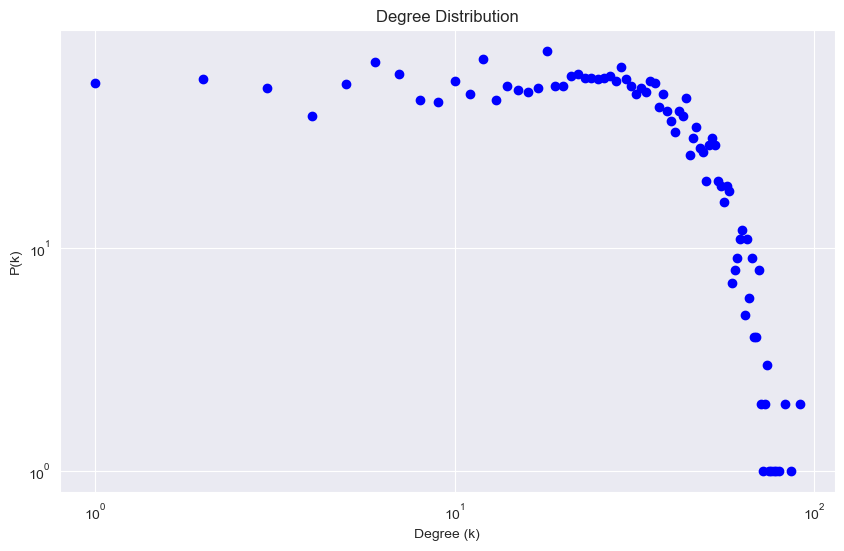

In [37]:
# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.loglog(degrees[degrees > 0], degree_count[degrees > 0], 'bo')  # Exclude zero degree entries
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution")
plt.show()

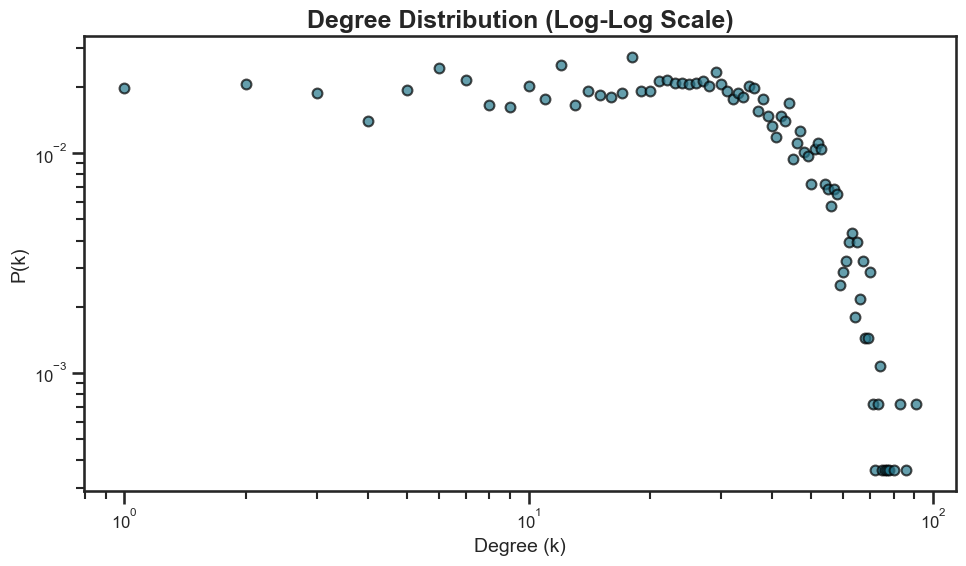

In [38]:
# Plot the logarithmic degree distribution

def plot_log_log_degree_dist(
    G, 
    filename="log_log_degree_distribution.png", 
    ref_alpha=None, 
    ref_xmin=None
):
    # Extract degrees of nodes
    degrees = [G.degree(n) for n in G.nodes()]
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    
    # Compute P(k) = counts / total number of nodes
    pk = counts / len(degrees)
    
    # Set up Seaborn style
    sns.set(style="ticks", context="talk")  # Use "ticks" style for minimal grid
    palette = sns.color_palette("crest", as_cmap=True)  # New colormap
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for P(k) vs k
    plt.scatter(
        unique_degrees, 
        pk, 
        color=palette(0.6),  # Pick a distinct color
        alpha=0.7, 
        s=50, 
        edgecolor="black", 
        label="Observed P(k)"
    )
    
    # Add a reference power-law line if specified
    if ref_alpha is not None and ref_xmin is not None:
        x_ref = np.array(sorted(unique_degrees[unique_degrees >= ref_xmin]))
        y_ref = (x_ref ** (-ref_alpha)) / np.sum(x_ref ** (-ref_alpha))
        plt.plot(
            x_ref, y_ref, 
            linestyle="--", color="red", linewidth=2, 
            label=f"Power-law fit (α={ref_alpha:.2f}, xmin={ref_xmin})"
        )
    
    # Add title and labels
    plt.title("Degree Distribution (Log-Log Scale)", fontsize=18, weight='bold')
    plt.xlabel("Degree (k)", fontsize=14)
    plt.ylabel("P(k)", fontsize=14)
    
    # Log-log scale
    plt.xscale("log")
    plt.yscale("log")
    
    # Customize ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Save the plot to a file
    plt.tight_layout()
    plt.savefig(filename, dpi=600, bbox_inches='tight')  # Save with high resolution
    
    # Show the plot
    plt.show()

plot_log_log_degree_dist(graph_largest)

### Is our network scale-free?

In [40]:
# Fit the degree sequence to a power law
fit = powerlaw.Fit(degree_sequence)

# Check the power law exponent
print("Power law alpha:", fit.power_law.alpha)
print("xmin for power law fit:", fit.power_law.xmin)

# Compare power-law fit with other distributions
R, p = fit.distribution_compare('power_law', 'exponential')
print("Likelihood ratio R:", R)
print("p-value:", p)

Power law alpha: 14.108294576605937
xmin for power law fit: 65.0
Likelihood ratio R: 0.538158801531007
p-value: 0.2599068976144647


Calculating best minimal value for power law fit
/opt/anaconda3/envs/social_graphs/lib/python3.12/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


The high $\alpha$ value and the p-value indicate that the degree distribution is unlikely to follow a power-law.

### Plot the base network

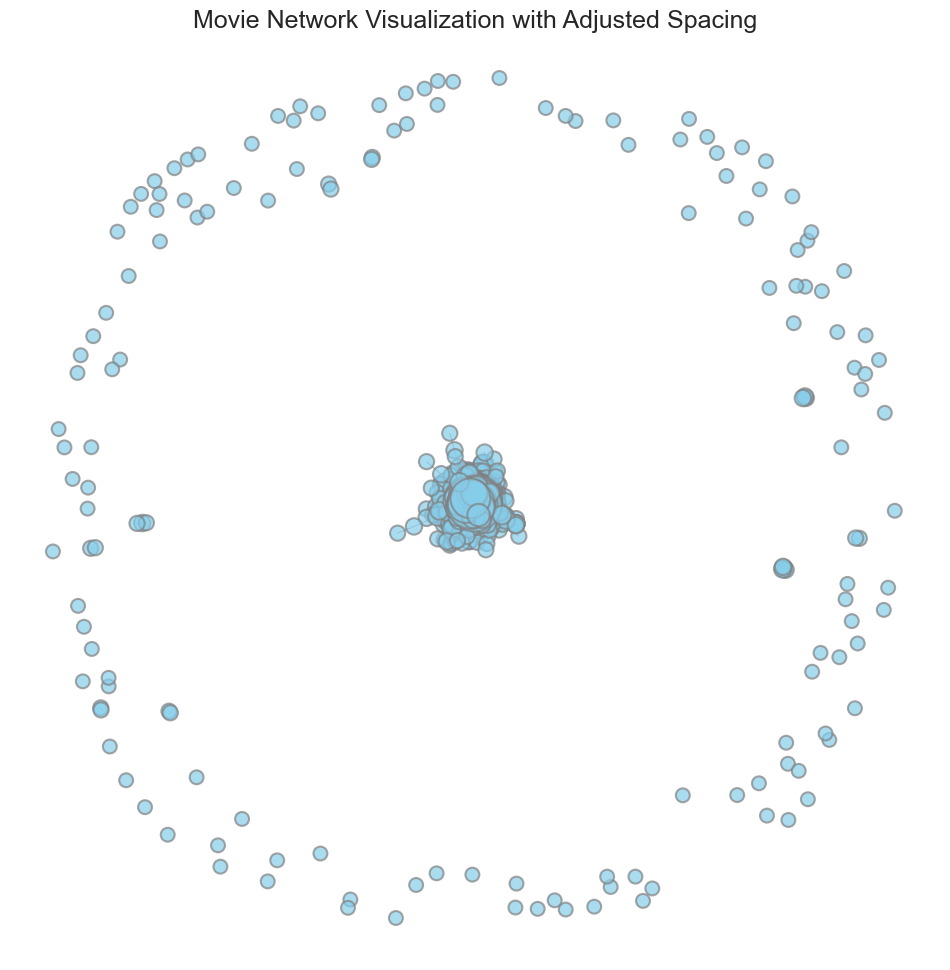

In [41]:
# Calculate node sizes based on degree
node_sizes = [100 + 20 * movie_graph.degree(node) for node in movie_graph.nodes]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(movie_graph, seed=42)

# Draw nodes with varying size
nx.draw_networkx_nodes(movie_graph, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7, edgecolors="gray")

# Draw edges
nx.draw_networkx_edges(movie_graph, pos, width=0.5, alpha=0.5)

plt.title("Movie Network Visualization with Adjusted Spacing")
plt.axis("off")
plt.show()


### Plot the extracted largest component

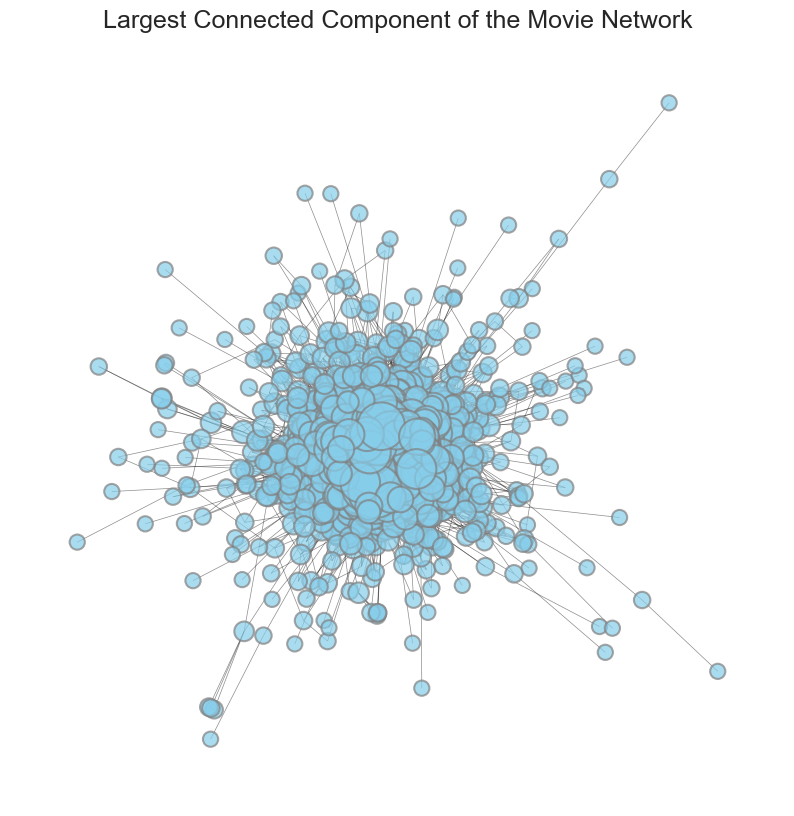

In [42]:
# Calculate node sizes based on degree in the subgraph
node_sizes = [100 + 20 * graph_largest.degree(node) for node in graph_largest.nodes]

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph_largest, seed=42)

# Draw nodes with varying size
nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7, edgecolors="gray")

# Draw edges
nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)

plt.title("Largest Connected Component of the Movie Network")
plt.axis("off")
plt.show()


### Kamada layout   

In [43]:
# Use Kamada-Kawai layout instead
pos = nx.kamada_kawai_layout(graph_largest)

nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7, edgecolors="gray")
nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)
plt.title("Movie Network Visualization with Kamada-Kawai Layout")
plt.axis("off")
plt.show()


KeyboardInterrupt: 

### Network Visualisation

We used Graphistry tool to make an interactive visualisation of our network in order to use it in our presentation

In [44]:
# Data preprocessing for graphistry library needs

initial_pos = {n: np.random.rand(2) for n in graph_largest.nodes}
pos = nx.spring_layout(graph_largest, k=2.0, iterations=50, pos=initial_pos)

# Node DataFrame, including 'actors' attribute
nodes_df = pd.DataFrame.from_dict(dict(graph_largest.nodes(data=True)), orient='index')
nodes_df['degree'] = [graph_largest.degree[node] for node in graph_largest.nodes]
nodes_df['x'] = [pos[node][0] for node in graph_largest.nodes]
nodes_df['y'] =  [pos[node][1] for node in graph_largest.nodes]

# Edge DataFrame
edges_df = nx.to_pandas_edgelist(graph_largest)
edges_df['source'] = edges_df['source'].astype(str)
edges_df['target'] = edges_df['target'].astype(str)

# Make the plot in the visualisation undirected
edges_df['edge'] = edges_df.apply(lambda row: tuple(sorted([row['source'], row['target']])), axis=1)
undirected_edges_df = edges_df.drop_duplicates(subset='edge').drop(columns='edge').reset_index(drop=True)

# Replace non-numeric values with NaN and convert column to numeric
nodes_df['domestic'] = pd.to_numeric(nodes_df['domestic'], errors='coerce')
nodes_df['international'] = pd.to_numeric(nodes_df['international'], errors='coerce')
nodes_df["run_time"] = pd.to_numeric(nodes_df["run_time"], errors='coerce')

In [112]:
# Bind the nodes and edges to Graphistry, specifying the source, destination, and node key
# Set up Graphistry (replace with your credentials or use environment variables)

graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="michalis", password="FDKeHQR4EQg7pvb")

graphistry.bind(source="source", destination="target", point_x="x", point_y="y") \
    .edges(undirected_edges_df) \
    .nodes(nodes_df.reset_index(), node="index") \
    .encode_point_size("degree") \
    .plot()

Failed memoization speedup attempt due to Pandas internal hash function failing. Continuing without memoization speedups.This is fine, but for speedups around skipping re-uploads of previously seen tables, try identifying which columns have types that Pandas cannot hash, and convert them to hashable types like strings.

## Sentiment analysis in the largest network component

#### Node Sizes and Colors Based on Mean Compound Sentiment (Red to Green)

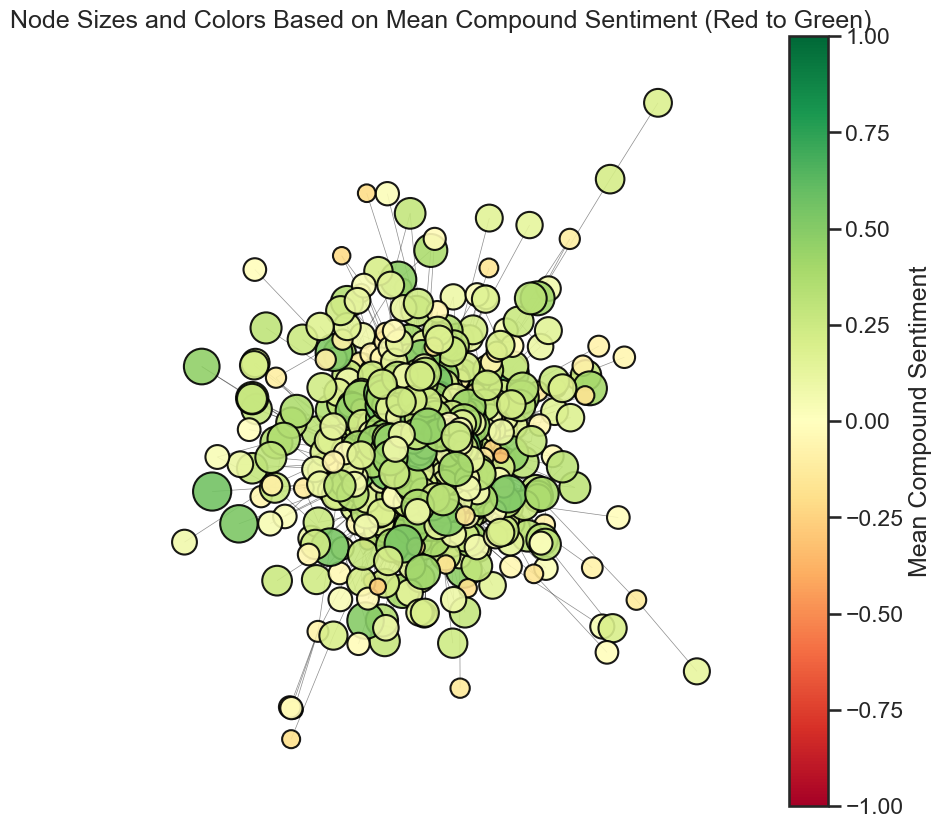

In [47]:
# Extract sentiment values
sentiments = [graph_largest.nodes[node]['mean_compound_sentiment'] for node in graph_largest.nodes]

# Normalize sentiment values to a range (100 to 2000) with exponential scaling
min_size, max_size = 50, 1000
min_sent, max_sent = min(sentiments), max(sentiments)
node_sizes = [
    min_size + (max_size - min_size) * ((sent - min_sent) / (max_sent - min_sent))**2 if max_sent > min_sent else min_size
    for sent in sentiments
]

norm = mcolors.Normalize(vmin=-1, vmax=1)  # Normalize between -1 and 1
cmap = cm.RdYlGn

# ScalarMappable for the colormap
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph_largest, seed=42)

# Draw nodes with varying size and color
colors = [cmap(norm(sent)) for sent in sentiments]
nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color=colors, alpha=0.9, edgecolors="black")

nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)

# Add the colorbar
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly associate the colorbar with the current axis
cbar.set_label("Mean Compound Sentiment")

plt.title("Node Sizes and Colors Based on Mean Compound Sentiment (Red to Green)")
plt.axis("off")
plt.show()

#### Node Sizes by Degree and Colors by Sentiment (Red to Green)

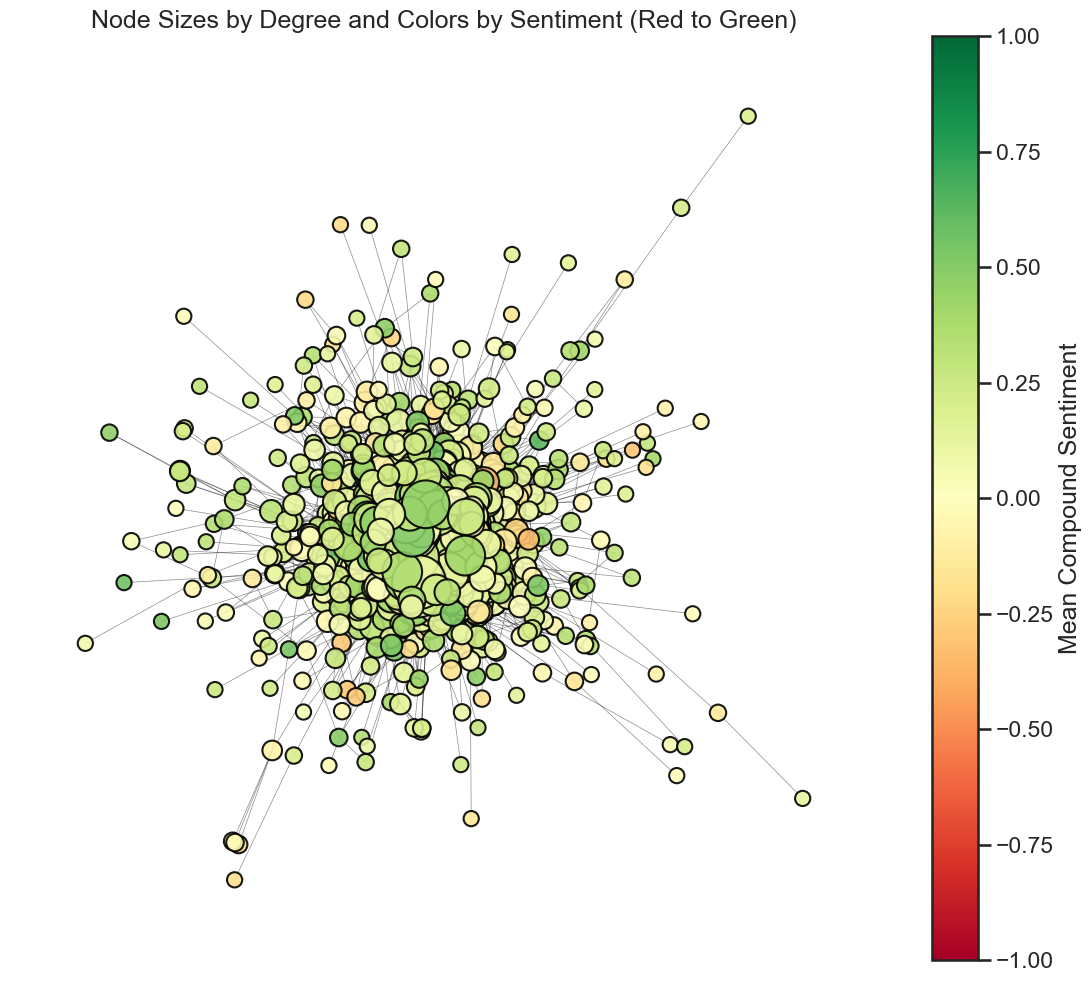

In [48]:
# Calculate node sizes based on degree in the subgraph
node_sizes = [100 + 20 * graph_largest.degree(node) for node in graph_largest.nodes]

# Extract sentiment values
sentiments = [graph_largest.nodes[node]['mean_compound_sentiment'] for node in graph_largest.nodes]

# Map sentiment values to a Red-to-Green color gradient
norm = mcolors.Normalize(vmin=-1, vmax=1)  # Normalize between -1 and 1
cmap = cm.RdYlGn

# Create a ScalarMappable for the colormap
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.figure(figsize=(14, 12))
pos = nx.spring_layout(graph_largest, seed=42)

# Draw nodes with varying size (degree) and color (sentiment)
colors = [cmap(norm(sent)) for sent in sentiments]
nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color=colors, alpha=0.9, edgecolors="black")

nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)

# Add the colorbar
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly associate the colorbar with the current axis
cbar.set_label("Mean Compound Sentiment")

plt.title("Node Sizes by Degree and Colors by Sentiment (Red to Green)")
plt.axis("off")
plt.show()

#### Distribution of Mean Compound Sentiment

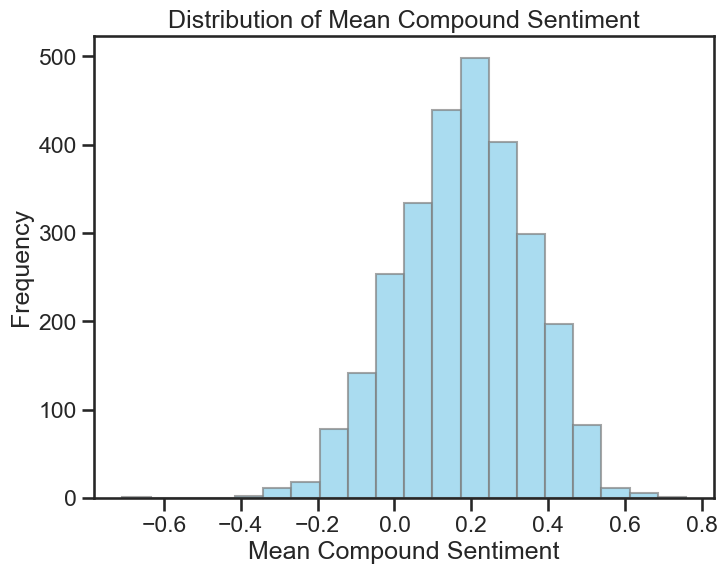

In [50]:
# Extract mean compound sentiment values
sentiments = [graph_largest.nodes[node]['mean_compound_sentiment'] for node in graph_largest.nodes]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(sentiments, bins=20, color='skyblue', edgecolor='gray', alpha=0.7)
plt.title("Distribution of Mean Compound Sentiment")
plt.xlabel("Mean Compound Sentiment")
plt.ylabel("Frequency")
plt.show()


#### Node Degree vs. Mean Compound Sentiment

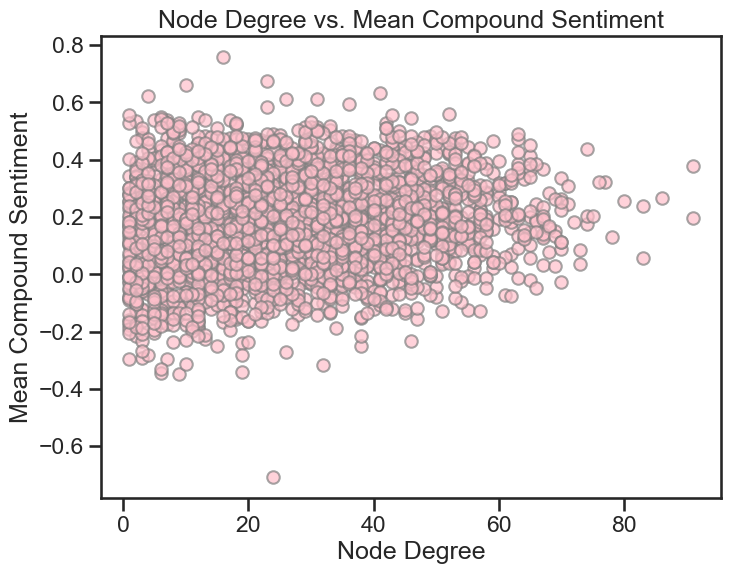

In [51]:
# Extract degrees and sentiment scores
degrees = [graph_largest.degree(node) for node in graph_largest.nodes]
sentiments = [graph_largest.nodes[node]['mean_compound_sentiment'] for node in graph_largest.nodes]

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(degrees, sentiments, alpha=0.7, color='pink', edgecolor='gray')
plt.title("Node Degree vs. Mean Compound Sentiment")
plt.xlabel("Node Degree")
plt.ylabel("Mean Compound Sentiment")
plt.show()


#### Average Sentiment Over Time

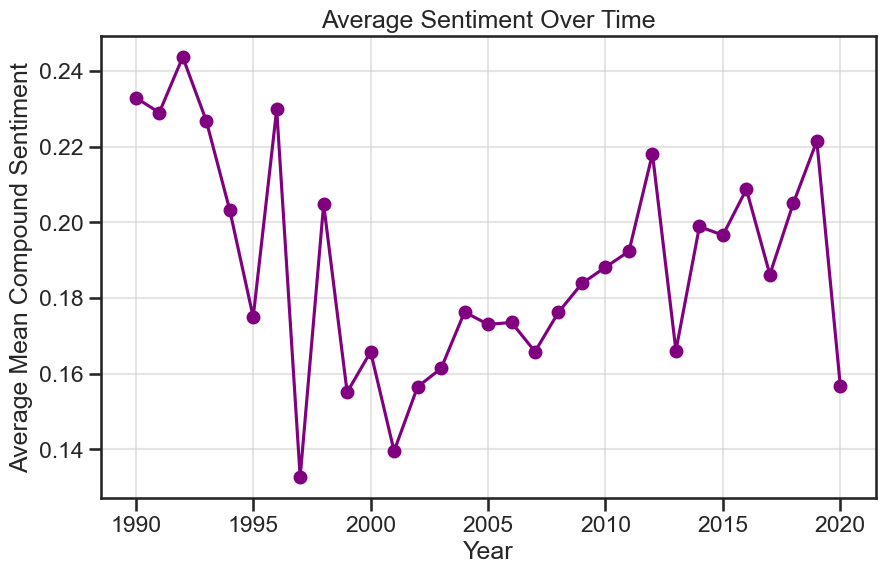

In [83]:
# Group sentiment by release year
years = [graph_largest.nodes[node]['release_year'] for node in graph_largest.nodes]
data = pd.DataFrame({'year': years, 'sentiment': sentiments})

# Calculate average sentiment per year
avg_sentiment_per_year = data.groupby('year')['sentiment'].mean()

# Line plot
plt.figure(figsize=(10, 6))
avg_sentiment_per_year.plot(color='purple', marker='o')
plt.title("Average Sentiment Over Time")
plt.xlabel("Year")
plt.ylabel("Average Mean Compound Sentiment")
plt.grid(alpha=0.5)
plt.show()


#### Top 10 Positive and Negative Sentiment Nodes - before sentiment adjustment

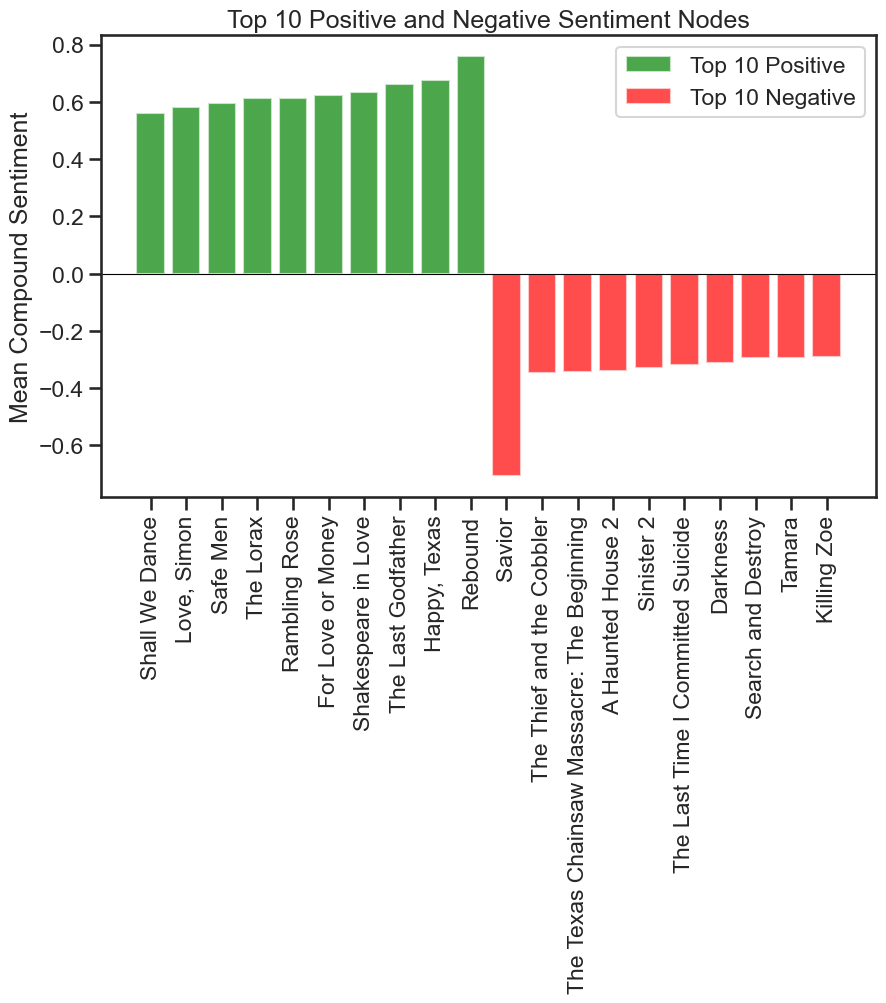

In [54]:
# Get top/bottom sentiment nodes
sorted_nodes = sorted(graph_largest.nodes, key=lambda node: graph_largest.nodes[node]['mean_compound_sentiment'])
top_10 = sorted_nodes[-10:]
bottom_10 = sorted_nodes[:10]

# Data for plotting
top_sentiments = [graph_largest.nodes[node]['mean_compound_sentiment'] for node in top_10]
bottom_sentiments = [graph_largest.nodes[node]['mean_compound_sentiment'] for node in bottom_10]

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(10), top_sentiments, color='green', alpha=0.7, label="Top 10 Positive")
plt.bar(range(10, 20), bottom_sentiments, color='red', alpha=0.7, label="Top 10 Negative")
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(range(20), labels=[*top_10, *bottom_10], rotation=90)
plt.title("Top 10 Positive and Negative Sentiment Nodes")
plt.ylabel("Mean Compound Sentiment")
plt.legend()
plt.show()


#### Top 10 Positive and Negative Sentiment Nodes - after sentiment adjustment

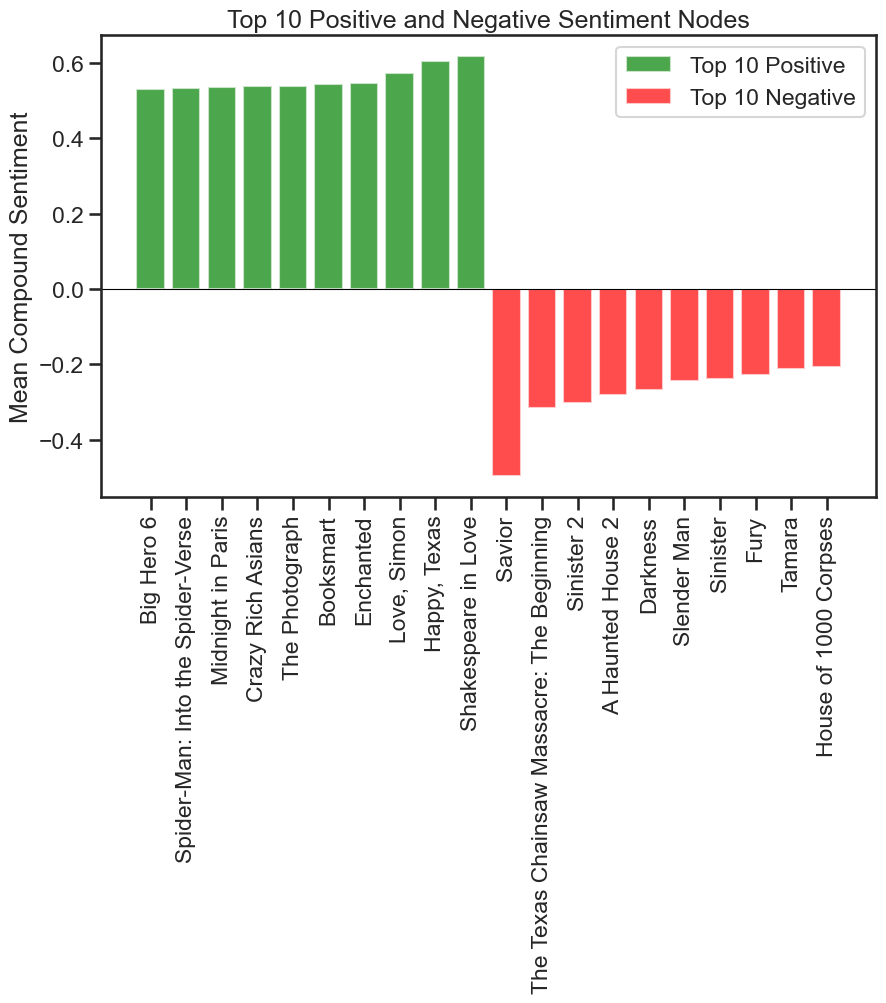

In [55]:
# Get top/bottom sentiment nodes
sorted_nodes = sorted(graph_largest.nodes, key=lambda node: graph_largest.nodes[node]['adjusted_sentiment'])
top_10 = sorted_nodes[-10:]
bottom_10 = sorted_nodes[:10]

# Data for plotting
top_sentiments = [graph_largest.nodes[node]['adjusted_sentiment'] for node in top_10]
bottom_sentiments = [graph_largest.nodes[node]['adjusted_sentiment'] for node in bottom_10]

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(10), top_sentiments, color='green', alpha=0.7, label="Top 10 Positive")
plt.bar(range(10, 20), bottom_sentiments, color='red', alpha=0.7, label="Top 10 Negative")
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(range(20), labels=[*top_10, *bottom_10], rotation=90)
plt.title("Top 10 Positive and Negative Sentiment Nodes")
plt.ylabel("Mean Compound Sentiment")
plt.legend()
plt.show()


#### Comparing the sentiment calculated with the Rotten Tomato critic score.

In [70]:
scores = [(movie_graph.nodes[movie]['mean_compound_sentiment'], graph_largest.nodes[movie]['tomatoMeter']) 
          for movie in graph_largest.nodes
          if not (np.isnan(graph_largest.nodes[movie]['mean_compound_sentiment']) or np.isnan(graph_largest.nodes[movie]['tomatoMeter']) or
                   np.isinf(graph_largest.nodes[movie]['mean_compound_sentiment']) or np.isinf(graph_largest.nodes[movie]['tomatoMeter']))]

# Correlation between the sentiment of the movie and the tomatoMeter
pearson_corr, pearson_p = stats.pearsonr([score[0] for score in scores], [score[1] for score in scores])
spearman_corr, spearman_p = stats.spearmanr([score[0] for score in scores], [score[1] for score in scores])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.9f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.9f})")

# simple linear regression

slope, intercept, r, p, std_err = stats.linregress([score[0] for score in scores], [score[1] for score in scores])
# print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")

Pearson correlation: 0.544 (p-value: 0.000000000)
Spearman correlation: 0.549 (p-value: 0.000000000)
Linear regression: slope=90.566, intercept=36.274, r=0.544, p=0.000, std_err=2.727


Text(0, 0.5, 'TomatoMeter')

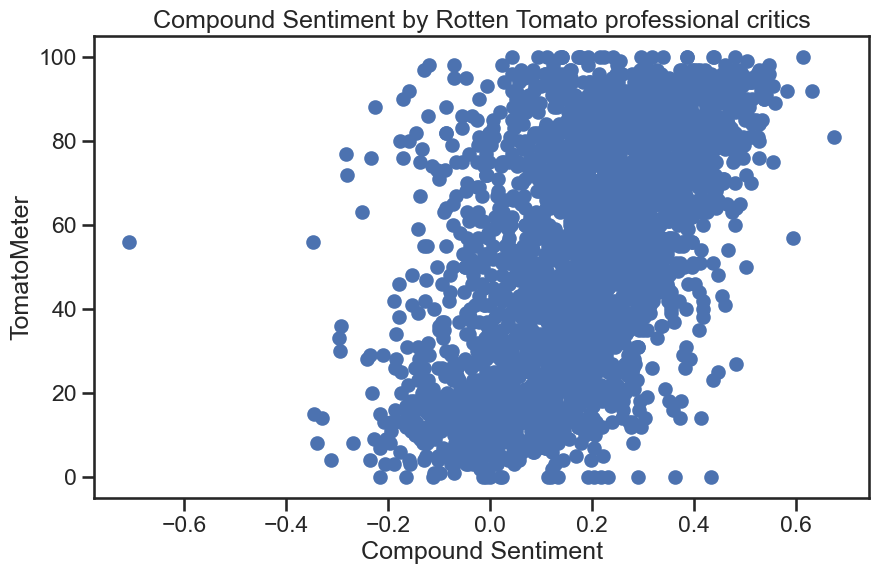

In [71]:
# compare with the sentiment
fig2, ax3 = plt.subplots(figsize=(10, 6))
ax3.scatter([score[0] for score in scores], [score[1] for score in scores])
ax3.set_title("Compound Sentiment by Rotten Tomato professional critics")
ax3.set_xlabel("Compound Sentiment")
ax3.set_ylabel("TomatoMeter")

#### Network homophily based on sentiment

Homophily measures the tendency of individuals to associate and bond with similar others in a network. In our case, we will calculate how similar the sentiments of connected movies are. This could reveal if actor-driven sentiment spreads across the network

In [117]:
# Define similarity of sentiments
adjusted_sentiment_per_node = nx.get_node_attributes(graph, 'adjusted_sentiment')
range_of_values = max(adjusted_sentiment_per_node.values()) - min(adjusted_sentiment_per_node.values())


def similarity(u, v):
    return 1 - abs(adjusted_sentiment_per_node[u] - adjusted_sentiment_per_node[v]) / range_of_values


# Calculate observed mean similarity
similarities = [similarity(u, v) for u, v in graph.edges]
mean_similarity_observed = np.mean(similarities)

# Generate a null model by shuffling node attributes
shuffled_values = list(adjusted_sentiment_per_node.values())
np.random.shuffle(shuffled_values)
shuffled_values_dict = dict(zip(graph.nodes, shuffled_values))


def null_similarity(u, v):
    return 1 - abs(shuffled_values_dict[u] - shuffled_values_dict[v]) / range_of_values


# Calculate null mean similarity
null_similarities = [null_similarity(u, v) for u, v in graph.edges]
mean_similarity_null = np.mean(null_similarities)

# Compare observed and null similarities
homophily_index = (mean_similarity_observed - mean_similarity_null) / mean_similarity_null

print(f"Observed Mean Similarity: {mean_similarity_observed}")
print(f"Null Mean Similarity: {mean_similarity_null}")
print(f"Homophily Index: {homophily_index}")

Observed Mean Similarity: 0.8592399754167913
Null Mean Similarity: 0.8432294983915067
Homophily Index: 0.018987093141102376


Homophily index value is approximately 0.019. This indicates that nodes that are connected do not have a much larger similarity of sentiment than they would have if they were randomly connected.


## Statistics on The Largest Component  
The next few block will show that there is correlation between the success metrics (profits, sentiment) and the popularity of the actors.

This block will prepare data for analysis. it will do the following 
- update the `actors_to_movies` dictionary such that actor wll be a key and the list of movies they acted in will be the value
- create an `actor_degree` dictionary which will have actors as keys and how many movies they acted in as values
- create an `actor_avg_earning` dictionary which will have actors as keys and the mean of the profit of the movies they acted in
- create an `actor_avg_sentiment` dictionary which will have actors as keys and the mean of the sentiment of the reviews of the movies they acted in
- converting the dictionaries to lists, the average sentiment of the first element will refer to the same actor in another list

In [57]:
# Preparing the data for the analysis

# make a dictionary with the actors and the number of movies they have played and the profit they have made
actor_to_movies.clear()
for movie in graph_largest.nodes:
    actors = graph_largest.nodes[movie].get('actors', [])
    for actor in actors:
        if actor != "UNKNOWN":
            actor_to_movies[actor].add(movie)

    
actor_degree = {actor: len(actor_to_movies[actor]) for actor in actor_to_movies.keys()}
actor_avg_earning = {actor: np.mean([graph_largest.nodes[movie]['profit'] for movie in actor_to_movies[actor]]) for actor in actor_to_movies.keys()}
actor_avg_sentiment = {actor: np.mean([graph_largest.nodes[movie]['mean_compound_sentiment'] for movie in actor_to_movies[actor]]) for actor in actor_to_movies.keys()}

# convert the dictionaries to lists
keys = sorted(set(actor_degree.keys()) | set(actor_avg_earning.keys()))
actor_degree_ls = [actor_degree.get(k) for k in keys]
actor_avg_earning_ls = [actor_avg_earning.get(k) for k in keys]

keys = sorted(set(actor_degree.keys()) | set(actor_avg_sentiment.keys()))
actor_sentiment_ls = [actor_degree.get(k) for k in keys]
actor_avg_sentiment_ls = [actor_avg_sentiment.get(k) for k in keys]




Here we calculate the following metrics for the popularity of the actors and profits
- Pearson correlation 
- Pearson p-value for the null hypothesist that they are uncorrelated
- same using Spearman correlation
- a simple linear regression between the popularity of the actors and profits that returns the slope, intercept, standard error estimate of the slope
NOTE the linear regression is done by getting the mean of all the (mean) profits for the actors that have acted in the same number of movies, i.e  if 2 actors acted in 2 movies the mean of the profit generated by each actor is again averaged.   

In [61]:
# Calculate the Pearson and Spearman correlation coefficients
pearson_corr, pearson_p = stats.pearsonr(actor_degree_ls, actor_avg_earning_ls)
spearman_corr, spearman_p = stats.spearmanr(actor_degree_ls, actor_avg_earning_ls)

print(f"""
Pearson correlation between a movie's cast popularity and average earnings: {pearson_corr:.3f} (p-value: {pearson_p:.3f})
""")
print(f"Spearman correlation between a movie's cast popularity and average earnings:: {spearman_corr:.3f} (p-value: {spearman_p:.3f})\n")

# calculate the mean profit for each "level" of actor popularity
# simple linear regression
mean_by_degree = dict()
for degree, earning in zip(actor_degree_ls, actor_avg_earning_ls):
    if degree not in mean_by_degree:
        mean_by_degree.update({degree: [earning]})
    else:
        mean_by_degree[degree].append(earning)
mean_by_degree = {degree: np.mean(earnings) for degree, earnings in mean_by_degree.items()}

slope, intercept, r, p, std_err = stats.linregress([key for key in mean_by_degree.keys()], [value for value in mean_by_degree.values()])
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")



Pearson correlation between a movie's cast popularity and average earnings: 0.111 (p-value: 0.000)

Spearman correlation between a movie's cast popularity and average earnings:: 0.241 (p-value: 0.000)

Linear regression: slope=1193933.616, intercept=64910284.669, r=0.538, p=0.002, std_err=347666.856
t-test: t=-27.970, p=0.000
Welch's t-test: t=-27.970, p=0.000
T-test for the dict where it shows the mean profit for each category of actor popularity
t-test: t=-22.806, p=0.000
Welch's t-test: t=-22.806, p=0.000


In [ ]:
# Perform t-tests
##Maybe does not make sense because they are not normally distributed
t_test = stats.ttest_ind(actor_degree_ls, actor_avg_earning_ls)
t_test_welch = stats.ttest_ind(actor_degree_ls, actor_avg_earning_ls, equal_var=False)

t_test_avg = stats.ttest_ind([key for key in mean_by_degree.keys()], [key for key in mean_by_degree.values()])
t_test_welch_avg = stats.ttest_ind([key for key in mean_by_degree.keys()], [key for key in mean_by_degree.values()])


print(f"t-test: t={t_test.statistic:.3f}, p={t_test.pvalue:.3f}")
print(f"Welch's t-test: t={t_test_welch.statistic:.3f}, p={t_test_welch.pvalue:.3f}")

print("T-test for the dict where it shows the mean profit for each category of actor popularity")
print(f"t-test: t={t_test_avg.statistic:.3f}, p={t_test_avg.pvalue:.3f}") 
print(f"Welch's t-test: t={t_test_welch_avg.statistic:.3f}, p={t_test_welch_avg.pvalue:.3f}")

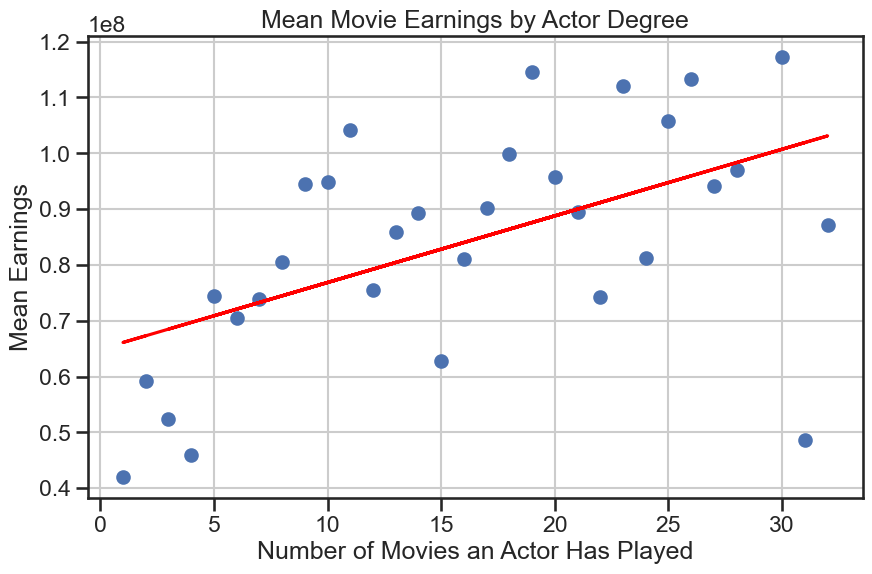

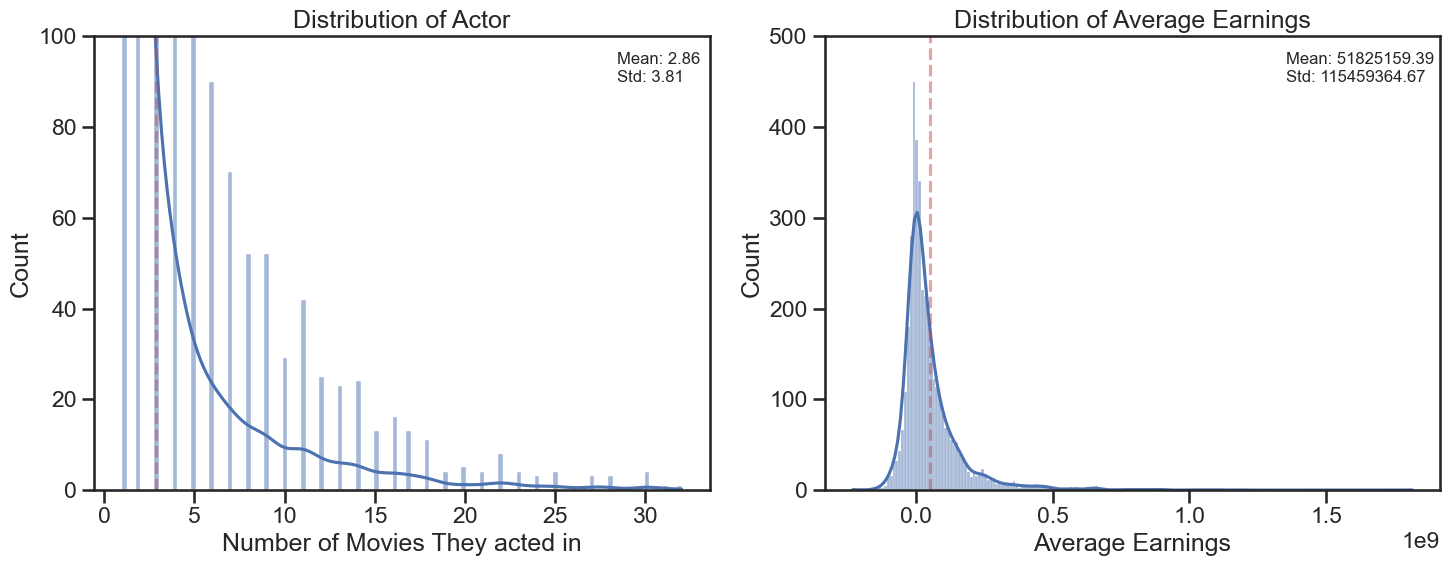

In [63]:
# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(mean_by_degree.keys(), mean_by_degree.values())
plt.plot([key for key in mean_by_degree.keys()], [slope * key + intercept for key in mean_by_degree.keys()], color='red')  
plt.xlabel('Number of Movies an Actor Has Played')
plt.ylabel('Mean Earnings')
plt.title('Mean Movie Earnings by Actor Degree')
plt.grid(True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Actor Degrees Distribution
sns.histplot(actor_degree_ls, kde=True, ax=ax1)
ax1.set_title('Distribution of Actor')
ax1.set_xlabel('Number of Movies They acted in')
ax1.set_ylabel('Count')
ax1.set_ylim(0, 100)

# Add mean and std annotations
mean_degree = np.mean(actor_degree_ls)
std_degree = np.std(actor_degree_ls)
ax1.axvline(mean_degree, color='r', linestyle='--', alpha=0.5)
ax1.text(0.85, 0.9, f'Mean: {mean_degree:.2f}\nStd: {std_degree:.2f}', 
         transform=ax1.transAxes, fontsize=12)

# Plot 2: Average Earnings Distribution
sns.histplot(actor_avg_earning_ls, kde=True, ax=ax2)
ax2.set_title('Distribution of Average Earnings')
ax2.set_xlabel('Average Earnings')
ax2.set_ylabel('Count')
ax2.set_ylim(0, 500)

# Add mean and std annotations
mean_earning = np.mean(actor_avg_earning_ls)
std_earning = np.std(actor_avg_earning_ls)
ax2.axvline(mean_earning, color='r', linestyle='--', alpha=0.5)
ax2.text(0.75, 0.90, f'Mean: {mean_earning:.2f}\nStd: {std_earning:.2f}', 
         transform=ax2.transAxes, fontsize=12)

plt.tight_layout()
plt.show()

Here we calculate the following metrics for the popularity of the actors and sentiment
- Pearson correlation 
- Pearson p-value for the null hypothesist that they are uncorrelated
- same using Spearman correlation
- a simple linear regression between the popularity of the actors and sentiment that returns the slope, intercept, standard error estimate of the slope


NOTE the linear regression is done by getting the mean of all the (mean) profits for the actors that have acted in the same number of movies, i.e  if 2 actors acted in 2 movies the mean of the sentiment by each actor is again averaged.   

In [66]:
## correlation between the popularity of the actors and the sentiment
pearson_corr, pearson_p = stats.pearsonr(actor_degree_ls, actor_avg_sentiment_ls)
spearman_corr, spearman_p = stats.spearmanr(actor_degree_ls, actor_avg_sentiment_ls)

print(f"Pearson correlation between a movie's cast popularity and average reviews sentiment: {pearson_corr:.3f} (p-value: {pearson_p:.4f})")
print(f"Spearman correlation between a movie's cast popularity and average reviews sentiment: {spearman_corr:.3f} (p-value: {spearman_p:.4f})")

Pearson correlation between a movie's cast popularity and average reviews sentiment: 0.062 (p-value: 0.0001)
Spearman correlation between a movie's cast popularity and average reviews sentiment: 0.045 (p-value: 0.0053)


In [ ]:
# simple linear regression sentiment
slope, intercept, r, p, std_err = stats.linregress(actor_degree_ls,actor_avg_sentiment_ls)
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")

# simple linear regression for the dict where it shows the mean sentiment for each "level" of actor popularity
mean_by_degree_sen = dict()
for degree, sentiment in zip(actor_degree_ls, actor_avg_sentiment_ls):
    if degree not in mean_by_degree_sen:
        mean_by_degree_sen.update({degree: [sentiment]})
    else:
        mean_by_degree_sen[degree].append(sentiment)
mean_by_degree_sen = {degree: np.mean(earnings) for degree, earnings in mean_by_degree_sen.items()}

slope, intercept, r, p, std_err = stats.linregress([key for key in mean_by_degree_sen.keys()], [value for value in mean_by_degree_sen.values()])
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")

##Result not linear

Text(0, 0.5, 'Frequency')

<Figure size 1000x600 with 0 Axes>

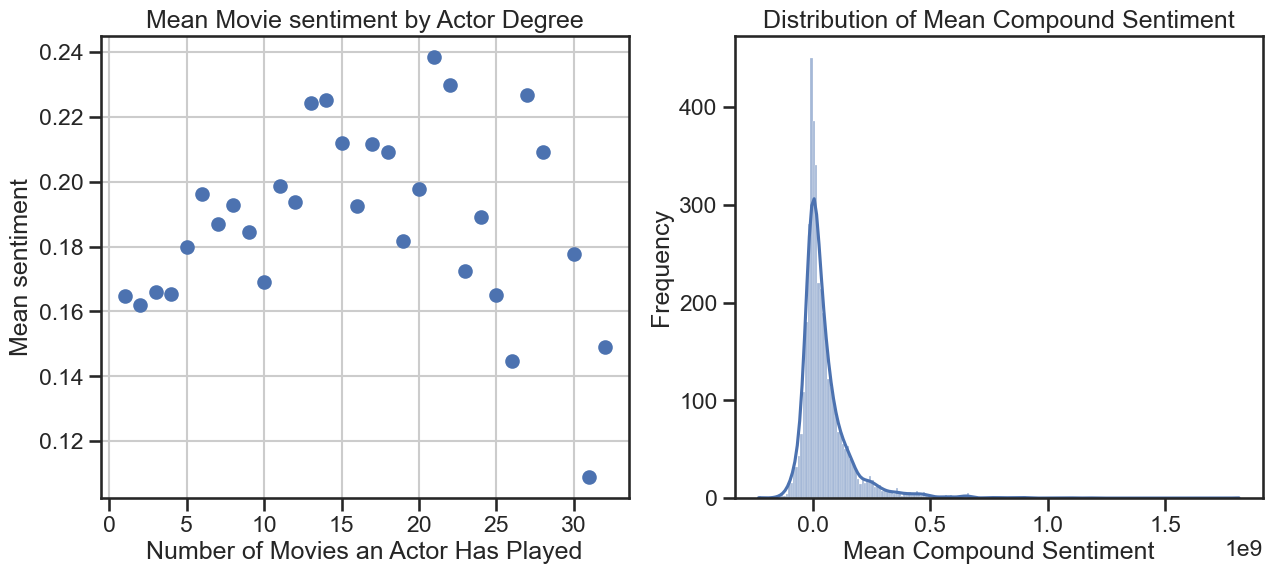

In [67]:
# Plot results
plt.figure(figsize=(10, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(mean_by_degree_sen.keys(), mean_by_degree_sen.values())
ax1.set_xlabel('Number of Movies an Actor Has Played')
ax1.set_ylabel('Mean sentiment')
ax1.set_title('Mean Movie sentiment by Actor Degree')
ax1.grid(True)

# histogram of the sentiment
sns.histplot(actor_avg_earning_ls, kde=True, ax=ax2)
ax2.set_title("Distribution of Mean Compound Sentiment")
ax2.set_xlabel("Mean Compound Sentiment")
ax2.set_ylabel("Frequency")

#### Total actor popularity compared with earnings and sentiment

In [121]:
# Find actor popularity in movies
appearances = nx.get_node_attributes(graph, 'actors')
flattened_appearances_list = list(chain.from_iterable(list(appearances.values())))
appearances_count = Counter(flattened_appearances_list)

# Add total popularity attribute
for node in graph.nodes:
    total_actor_popularity = sum([appearances_count[actor] for actor in appearances[node]])
    graph.nodes[node]["total_actor_popularity"] = total_actor_popularity

# Calculate the Pearson and Spearman correlation coefficients for total popularity and profit
total_actor_popularity = list(nx.get_node_attributes(graph, "total_actor_popularity").values())
profit = list(nx.get_node_attributes(graph, "profit").values())
pearson_corr, pearson_p = stats.pearsonr(total_actor_popularity, profit)
spearman_corr, spearman_p = stats.spearmanr(total_actor_popularity, profit)

print(f"---- Total actor popularity vs profit ----")
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

# Calculate the Pearson and Spearman correlation coefficients for total popularity and profit
adjusted_sentiment = list(nx.get_node_attributes(graph, "adjusted_sentiment").values())
pearson_corr, pearson_p = stats.pearsonr(total_actor_popularity, adjusted_sentiment)
spearman_corr, spearman_p = stats.spearmanr(total_actor_popularity, adjusted_sentiment)

print(f"\n---- Total actor popularity vs sentiment ----")
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

---- Total actor popularity vs profit ----
Pearson correlation: 0.163 (p-value: 0.000)
Spearman correlation: 0.139 (p-value: 0.000)

---- Total actor popularity vs sentiment ----
Pearson correlation: 0.133 (p-value: 0.000)
Spearman correlation: 0.128 (p-value: 0.000)


### Centrality

Here we calculate the centrality metrics for 
- Betweenness centrality
- Eigenvector_centrality
- Degree_centrality
- Edge_betweenness_centrality
see comments for info about what each mean

In [72]:
# Measures Betweenness centrality measures how often a node acts as a bridge along the shortest path between two other nodes.
bet_cent = nx.betweenness_centrality(graph_largest)

# Measures Eigenvector centrality measures a node's importance based on the importance of its neighbors. 
# It assigns relative scores to all nodes in the network based on the principle that connections 
# to high-scoring nodes contribute more to the score of the node in question.

# High Eigenvector Centrality: Nodes with high scores are influential because they are connected to other influential nodes. 
# In a social network, these could be key influencers who are well-connected to other influencers.
eig_cent = nx.eigenvector_centrality(graph_largest)

# Degree centrality measures the proportion of direct connections a node has relative to the total possible connections
deg_cent = nx.degree_centrality(graph_largest)

# Edge betweenness centrality measures how often an edge is part of the shortest paths between pairs of nodes
edge_bet = nx.edge_betweenness_centrality(graph_largest)

#### Top 5 movies/actors for each centrality metrics

In [77]:
top5Edges = sorted(edge_bet.items(), key=lambda x: x[1], reverse=True)[:5]
top5actors = []
for edge in top5Edges:
    movie1, movie2 = edge[0]
    for actor in graph_largest.nodes[movie1]['actors']:
        if actor in graph_largest.nodes[movie2]['actors']:
            top5actors.append(actor)

print("Top 5 actors in edges with the highest betweenness centrality", top5actors)
print("\nTop 5 nodes with the highest betweenness centrality", sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:5])
print("\nTop 5 nodes with the highest eigenvector centrality", sorted(eig_cent.items(), key=lambda x: x[1], reverse=True)[:5])
print("\nTop 5 nodes with the highest degree centrality", sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 actors in edges with the highest betweenness centrality ['Ben Mendelsohn', 'Angus Macfadyen', 'James DeBello', 'Dean Cain', 'Mackenzie Davis']

Top 5 nodes with the highest betweenness centrality [('Shark Tale', 0.004288706495710224), ('Pain & Gain', 0.004086286152985749), ('The Ant Bully', 0.003932049550063262), ('Captain Marvel', 0.0036510740547660513), ('Nurse Betty', 0.0032868787241085366)]

Top 5 nodes with the highest eigenvector centrality [("Ocean's Eleven", 0.09519889797752502), ('The Departed', 0.08486878846390782), ('Shark Tale', 0.07145619545278582), ("Ocean's Twelve", 0.07062921543648402), ('The Perfect Storm', 0.0700681496495838)]

Top 5 nodes with the highest degree centrality [("Ocean's Eleven", 0.032780979827089336), ('Shark Tale', 0.032780979827089336), ('The Ant Bully', 0.030979827089337175), ('Alexander', 0.029899135446685876), ('The Departed', 0.029899135446685876)]


## Community analysis

In [100]:
##Functions to calculate modularity
def dict_to_subgraphs(communities,G):
  subgraphs = []
  for key in communities.keys():
    nodes = communities[key]
    subgraph = G.subgraph(nodes)
    subgraphs.append(subgraph)
  return subgraphs

def modularity(subgraphs,G):
  L_c = [subgraph.number_of_edges() for subgraph in subgraphs]
  K_c = [sum([G.degree(node) for node in subgraph.nodes()]) for subgraph in subgraphs]
  M = sum([
    (L_c[i]/G.number_of_edges())-
    ((K_c[i]/(2*G.number_of_edges()))**2) for i in range(len(L_c))])
  return M

### Communities by genre

#### Create communities based on the first genre of a movie

In [81]:
## Find communities based on the first genre G
communities_first_genre = dict()
for node in graph_largest.nodes():
    if graph_largest.nodes(data=True)[node]["genres"][0] != "UNKNOWN":
        community = graph_largest.nodes(data=True)[node]["genres"][0]

        if community in communities_first_genre.keys():
            current = communities_first_genre[community]
            current.append(node)
            communities_first_genre[community]=current
        else:
            communities_first_genre.update({community:[node]})

num_communities = len(communities_first_genre)
print(f"Number of communities: {num_communities}")
print("Modularity based on genre", modularity(dict_to_subgraphs(communities_first_genre,graph_largest),graph_largest))

Number of communities: 14
Modularity based on genre 0.07607108018000766


#### Plot network with genre-based communities 

/var/folders/8h/82c89t014nv4j0sw212kn4640000gn/T/ipykernel_63141/3783787115.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab20", len(communities_first_genre))


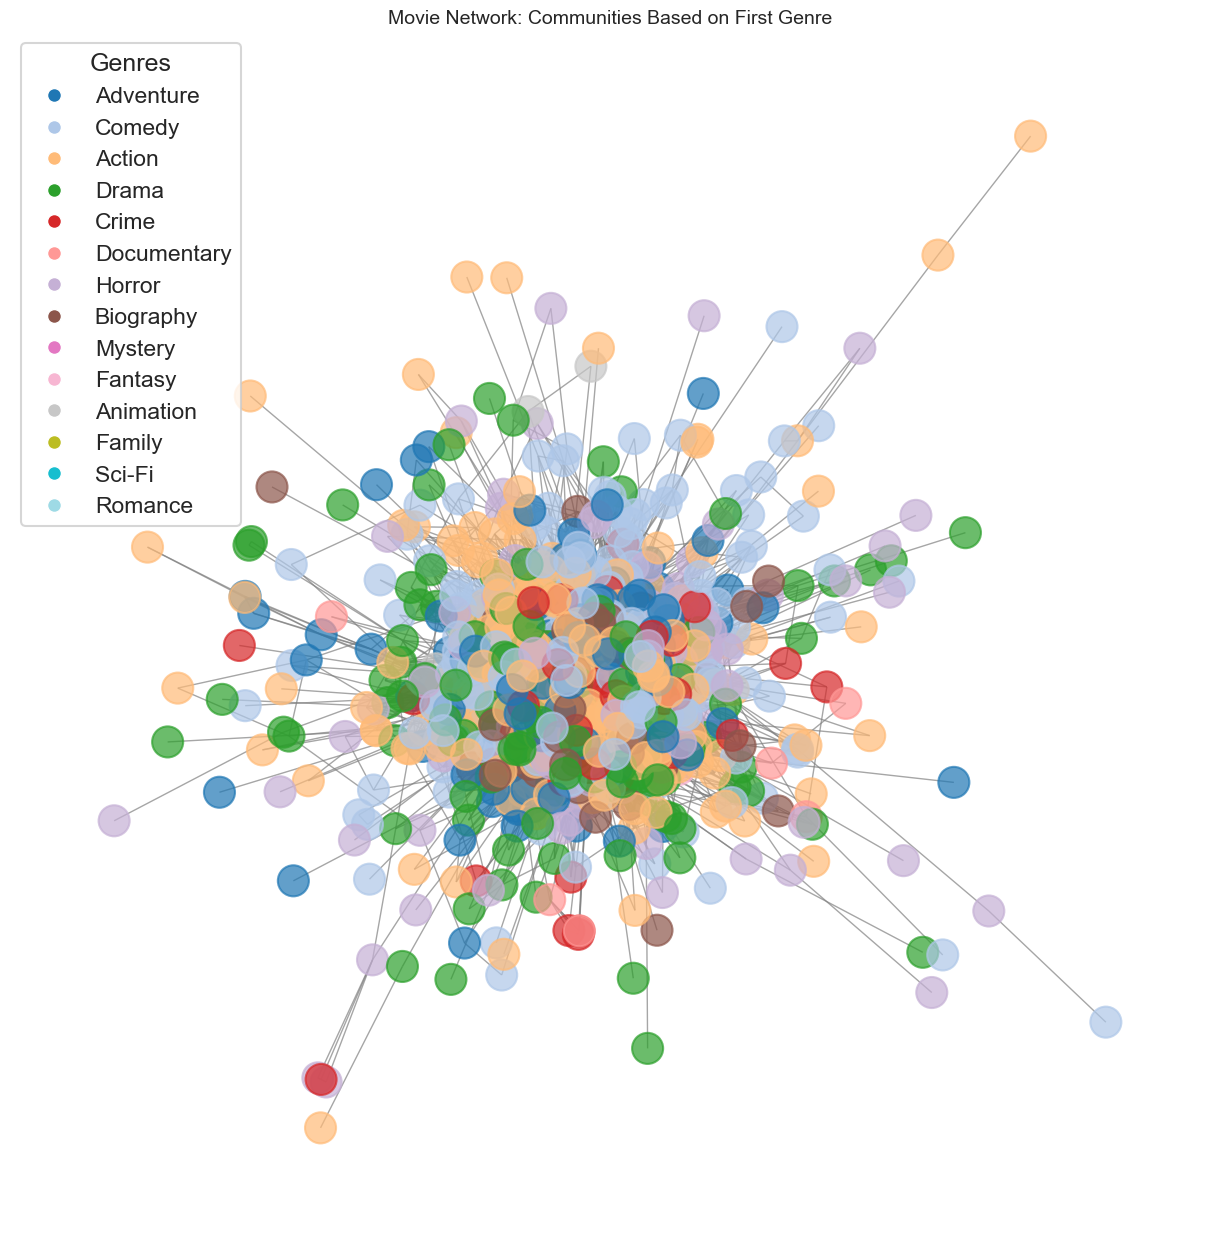

In [84]:
# Generate a color map based on the communities (genres)
color_map = plt.cm.get_cmap("tab20", len(communities_first_genre))

# Create a new plot
plt.figure(figsize=(12, 12))

# Create a list of colors for each node based on its genre community
node_colors = []
for node in graph_largest.nodes():
    # Get the first genre of the movie
    first_genre = graph_largest.nodes(data=True)[node]["genres"][0]
    
    if first_genre != "UNKNOWN":
        # Get the community index for the first genre
        community_idx = list(communities_first_genre.keys()).index(first_genre)
        node_colors.append(color_map(community_idx))
    else:
        node_colors.append((0.5, 0.5, 0.5))  # Default color for UNKNOWN genres

# Draw the network with communities as colors
pos = nx.spring_layout(graph_largest, seed=42)  # Layout for the graph (spring layout is just one option)
nx.draw(graph_largest, pos, node_color=node_colors, with_labels=False, node_size=500, font_size=10, font_weight="bold", edge_color="gray", alpha=0.7)

# Create a list of genres for the legend
genre_labels = list(communities_first_genre.keys())

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i), markersize=10) for i in range(len(genre_labels))]
plt.legend(handles, genre_labels, title="Genres", loc='best')
plt.title("Movie Network: Communities Based on First Genre", fontsize=14)
plt.show()

#### Sizes of communities

In [86]:
community_sizes_df = pd.DataFrame(
    [(community, len(nodes)) for community, nodes in communities_first_genre.items()],
    columns=["Community", "Size"]
).sort_values(by="Size", ascending=False)

print(community_sizes_df)


      Community  Size
2        Action   803
1        Comedy   762
3         Drama   435
0     Adventure   264
4         Crime   174
7     Biography   160
6        Horror   130
10    Animation    20
5   Documentary     9
8       Mystery     9
9       Fantasy     7
12       Sci-Fi     2
11       Family     1
13      Romance     1


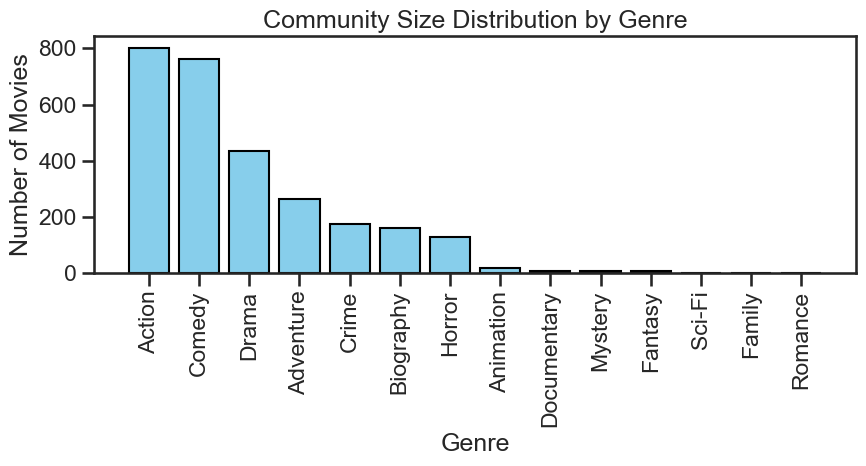

In [87]:
plt.figure(figsize=(9, 5)) 
plt.bar(community_sizes_df["Community"], community_sizes_df["Size"], color="skyblue", edgecolor="black")

# Customize ticks and labels
plt.xticks(rotation=90, ha="center")  # Align x-axis labels vertically
plt.ylabel("Number of Movies")
plt.xlabel("Genre")
plt.title("Community Size Distribution by Genre")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


#### Density of communities

In [88]:
subgraphs = dict_to_subgraphs(communities_first_genre, graph_largest)
densities_df = pd.DataFrame(
    [(list(communities_first_genre.keys())[i], nx.density(subgraph)) 
     for i, subgraph in enumerate(subgraphs)],
    columns=["Community", "Density"]
).sort_values(by="Density", ascending=False)

print(densities_df)


      Community   Density
5   Documentary  0.111111
4         Crime  0.017075
7     Biography  0.016903
10    Animation  0.015789
2        Action  0.014991
1        Comedy  0.013868
3         Drama  0.011823
0     Adventure  0.010860
6        Horror  0.008110
8       Mystery  0.000000
9       Fantasy  0.000000
11       Family  0.000000
12       Sci-Fi  0.000000
13      Romance  0.000000


#### Average degree of communities

In [89]:
avg_degrees = {key: sum([graph_largest.degree(node) for node in nodes]) / len(nodes)
               for key, nodes in communities_first_genre.items()}
print("Average degree of each community:", avg_degrees)


Average degree of each community: {'Adventure': 25.071969696969695, 'Comedy': 26.53018372703412, 'Action': 29.590286425902864, 'Drama': 26.850574712643677, 'Crime': 31.942528735632184, 'Documentary': 7.777777777777778, 'Horror': 12.446153846153846, 'Biography': 30.125, 'Mystery': 35.333333333333336, 'Fantasy': 39.285714285714285, 'Animation': 21.75, 'Family': 11.0, 'Sci-Fi': 46.5, 'Romance': 42.0}


#### SUMMARY TABLE - size, density, avg. degree

In [90]:
summary_df = pd.DataFrame(
    [
        (
            community,  # Community name
            len(nodes),  # Size (number of nodes in the community)
            nx.density(graph_largest.subgraph(nodes)),  # Density of the subgraph
            sum(graph_largest.degree(node) for node in nodes) / len(nodes)  # Average degree
        )
        for community, nodes in communities_first_genre.items()
    ],
    columns=["Community", "Size", "Density", "Average Degree"]
).sort_values(by="Size", ascending=False)

print(summary_df)


      Community  Size   Density  Average Degree
2        Action   803  0.014991       29.590286
1        Comedy   762  0.013868       26.530184
3         Drama   435  0.011823       26.850575
0     Adventure   264  0.010860       25.071970
4         Crime   174  0.017075       31.942529
7     Biography   160  0.016903       30.125000
6        Horror   130  0.008110       12.446154
10    Animation    20  0.015789       21.750000
5   Documentary     9  0.111111        7.777778
8       Mystery     9  0.000000       35.333333
9       Fantasy     7  0.000000       39.285714
12       Sci-Fi     2  0.000000       46.500000
11       Family     1  0.000000       11.000000
13      Romance     1  0.000000       42.000000


#### clustering coefficient for each community

In [91]:
# Compute clustering coefficient for each community
community_clustering = [
    (
        community,  # Community name
        nx.average_clustering(graph_largest.subgraph(nodes))  # Average clustering coefficient for the subgraph
    )
    for community, nodes in communities_first_genre.items()
]

clustering_df = pd.DataFrame(community_clustering, columns=["Community", "Clustering Coefficient"]).sort_values(
    by="Clustering Coefficient", ascending=False
)

print(clustering_df)


      Community  Clustering Coefficient
2        Action                0.447192
1        Comedy                0.438457
3         Drama                0.351768
4         Crime                0.338214
5   Documentary                0.333333
7     Biography                0.319482
0     Adventure                0.317040
6        Horror                0.153077
8       Mystery                0.000000
9       Fantasy                0.000000
10    Animation                0.000000
11       Family                0.000000
12       Sci-Fi                0.000000
13      Romance                0.000000


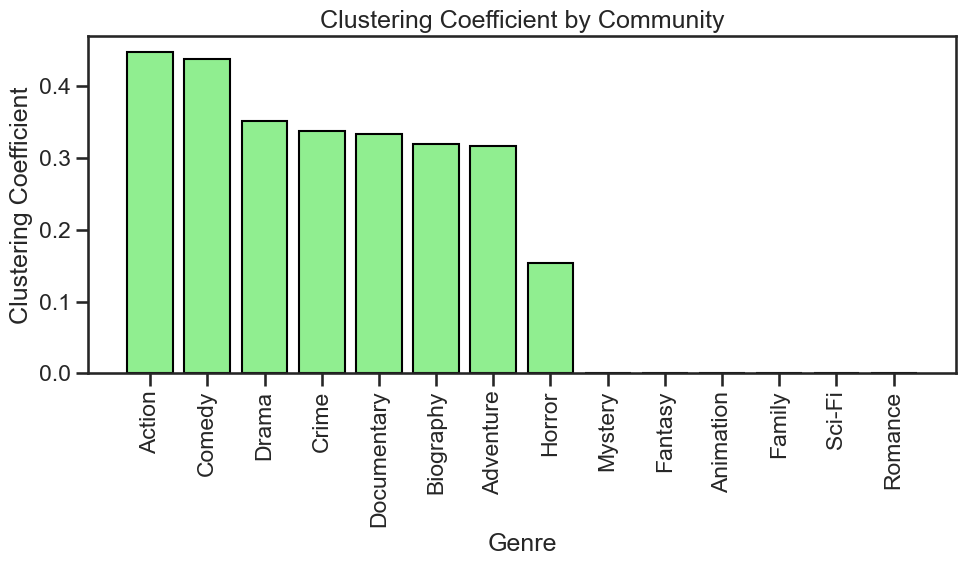

In [92]:
# Bar plot for clustering coefficients
plt.figure(figsize=(10, 6))
plt.bar(clustering_df["Community"], clustering_df["Clustering Coefficient"], color="lightgreen", edgecolor="black")
plt.xticks(rotation=90, ha="center")
plt.ylabel("Clustering Coefficient")
plt.xlabel("Genre")
plt.title("Clustering Coefficient by Community")
plt.tight_layout()
plt.show()


#### Inter-Community Edges


In [93]:
# Map each node to its community
node_to_community = {
    node: community
    for community, nodes in communities_first_genre.items()
    for node in nodes
}

# Count inter-community edges
inter_community_edges = sum(
    1 for u, v in graph_largest.edges()
    if node_to_community.get(u) != node_to_community.get(v)
)

# Total edges
total_edges = graph_largest.number_of_edges()

# Proportion of inter-community edges
inter_community_ratio = inter_community_edges / total_edges

print(f"Number of inter-community edges: {inter_community_edges}")
print(f"Proportion of inter-community edges: {inter_community_ratio:.2f}")


Number of inter-community edges: 26870
Proportion of inter-community edges: 0.71


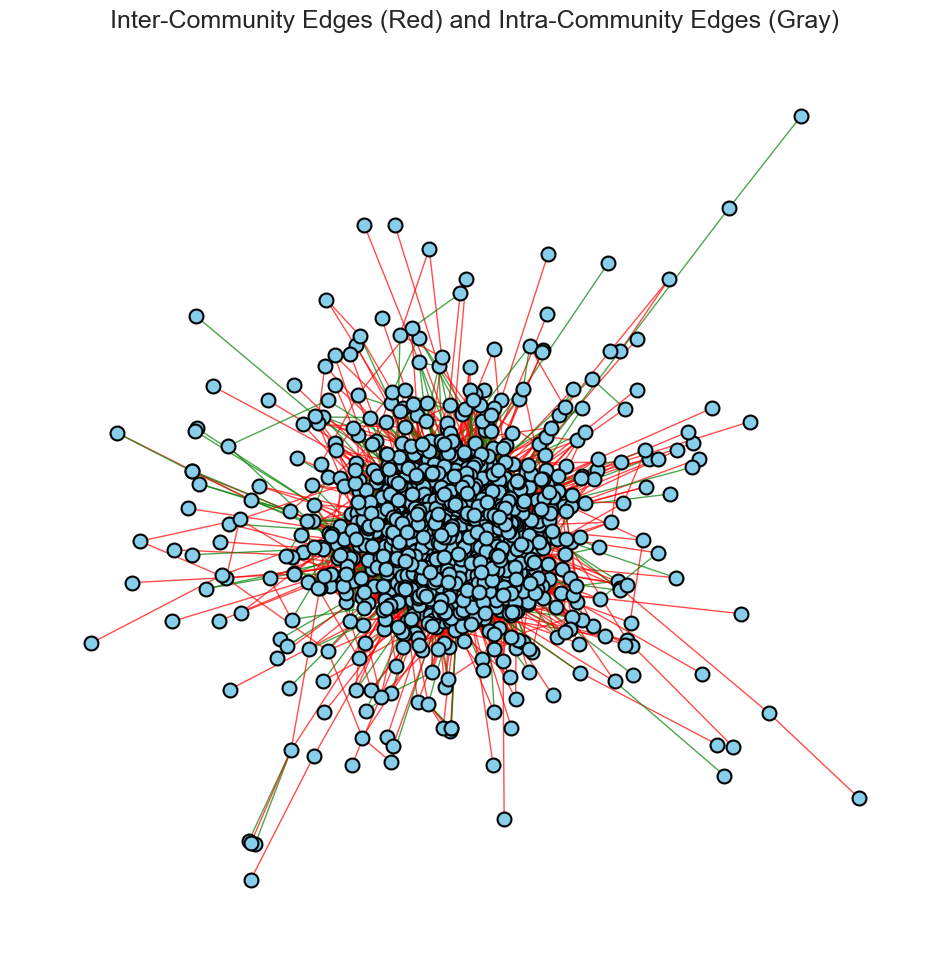

In [94]:
edge_colors = [
    "red" if node_to_community.get(u) != node_to_community.get(v) else "green"
    for u, v in graph_largest.edges()
]

# Draw the graph with edge coloring
pos = nx.spring_layout(graph_largest, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(graph_largest, pos, node_color="skyblue", edgecolors="black", node_size=100)
nx.draw_networkx_edges(graph_largest, pos, edge_color=edge_colors, alpha=0.7)
plt.title("Inter-Community Edges (Red) and Intra-Community Edges (Gray)")
plt.axis("off")
plt.show()


#### Graphs of each genre community

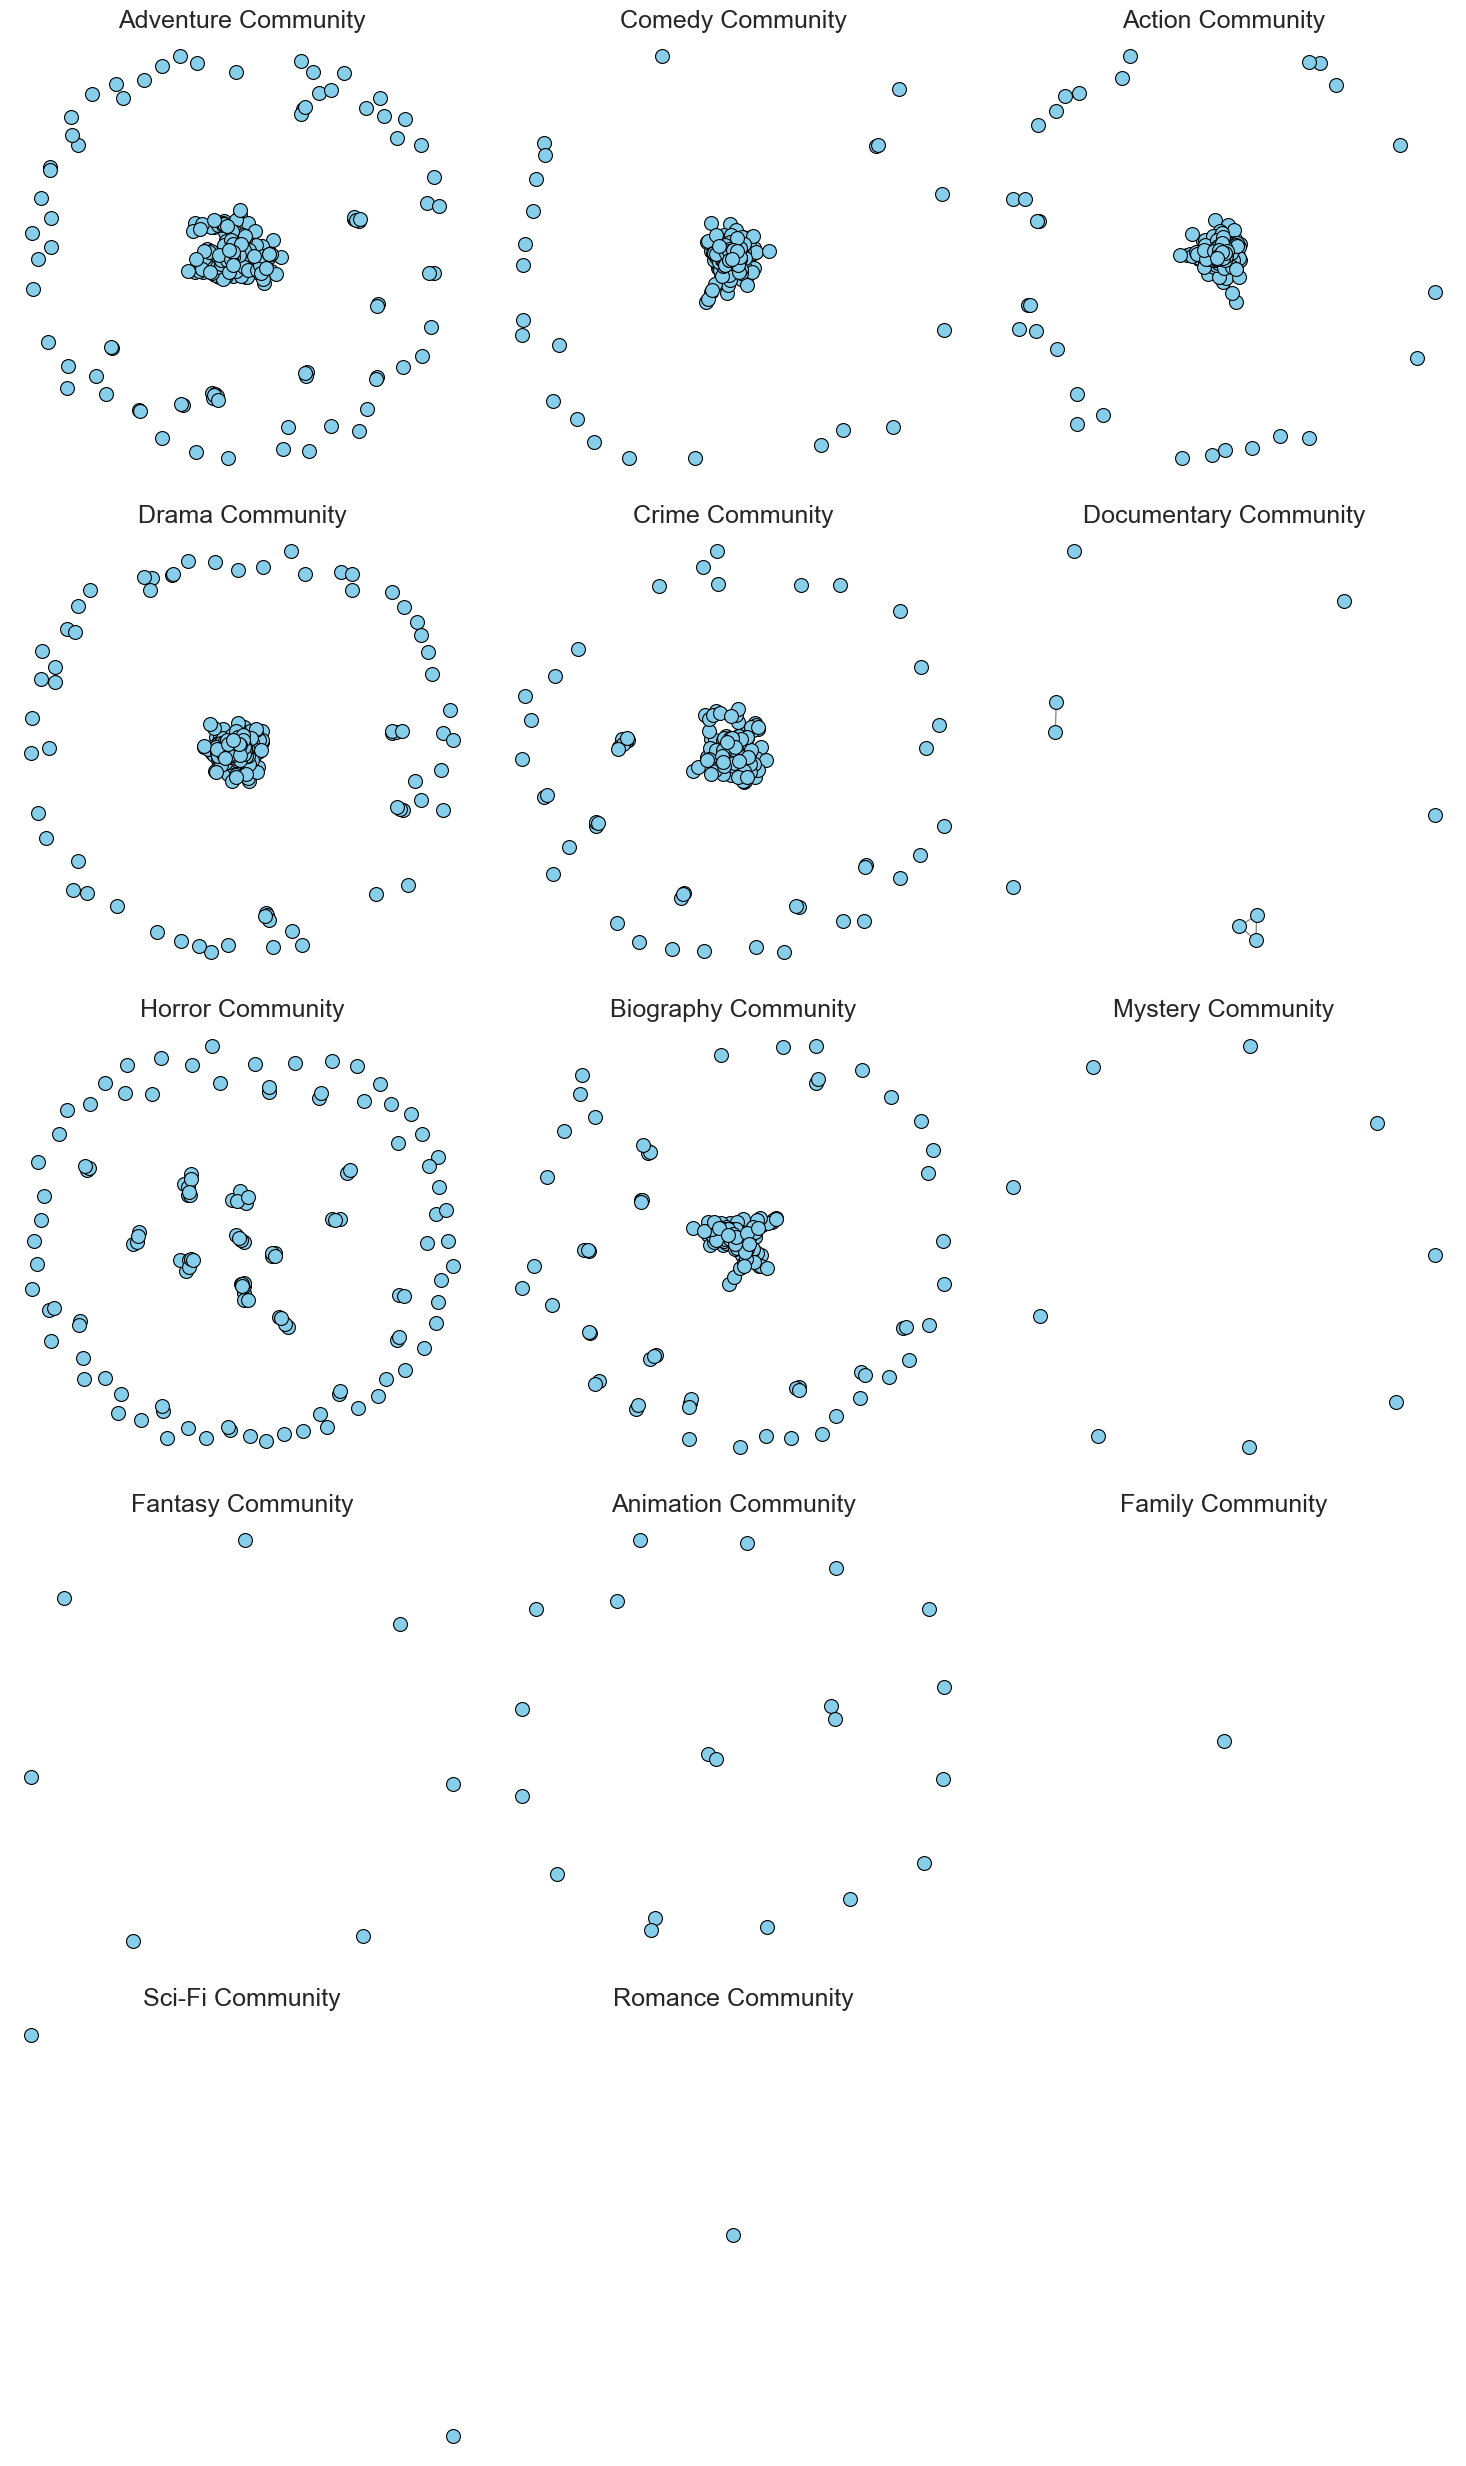

In [95]:
import networkx as nx
import matplotlib.pyplot as plt
import math

num_communities = len(communities_first_genre)
cols = 3
rows = math.ceil(num_communities / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Plot each community in its subplot
for idx, (key, subgraph) in enumerate(zip(communities_first_genre.keys(), subgraphs)):
    ax = axes[idx]
    pos = nx.spring_layout(subgraph, seed=42)

    nx.draw_networkx_nodes(subgraph, pos, 
                           ax=ax,
                           node_color='skyblue', 
                           edgecolors='black', 
                           linewidths=0.8, 
                           node_size=100)
    nx.draw_networkx_edges(subgraph, pos, ax=ax, alpha=0.5)

    ax.set_title(f"{key} Community")
    ax.axis("off")

for ax in axes[num_communities:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


### Communities by budget
Here we wil split movies based on tiers of budgets and put them in a communities, to see if spending more money on a movie means that you will earn more money.
The tiers are 
- 0 - 1,000,000
- 1,000,000 - 10,000,000
- 10,000,000 - 20,000,000
- 20,000,000 - 30,000,000
- 30,000,000 - 50,000,000
- 50,000,000 - 75,000,000
- 75,000,000 - 100,000,000
- 100,000,000 -200,000,000
- 200,000,000 +

In [96]:
budget_Communities = {
    "0 - 1,000,000": [],
    "1,000,000 - 10,000,000": [],
    "10,000,000 - 20,000,000": [],
    "20,000,000 - 30,000,000": [],
    "30,000,000 - 50,000,000": [],
    "50,000,000 - 75,000,000": [],
    "75,000,000 - 100,000,000": [],
    "100,000,000 - 200,000,000": [],
    "200,000,000 +": []
}

# Assuming graph_largest is your graph
for node in graph_largest.nodes:
    budget = graph_largest.nodes[node]["budget"]
    if budget < 1000000:
        budget_Communities["0 - 1,000,000"].append(node)
    elif budget < 10000000:
        budget_Communities["1,000,000 - 10,000,000"].append(node)
    elif budget < 20000000:
        budget_Communities["10,000,000 - 20,000,000"].append(node)
    elif budget < 30000000:
        budget_Communities["20,000,000 - 30,000,000"].append(node)
    elif budget < 50000000:
        budget_Communities["30,000,000 - 50,000,000"].append(node)
    elif budget < 75000000:
        budget_Communities["50,000,000 - 75,000,000"].append(node)
    elif budget < 100000000:
        budget_Communities["75,000,000 - 100,000,000"].append(node)
    elif budget < 200000000:
        budget_Communities["100,000,000 - 200,000,000"].append(node)
    else:
        budget_Communities["200,000,000 +"].append(node)



####################################
# copy = graph_largest.copy()
# for edge in copy.edges():
#     copy.edges[edge]['weight'] = (1 - abs(copy.nodes[edge[0]]["budget"] - copy.nodes[edge[1]]["budget"])/max(copy.nodes[edge[0]]["budget"], copy.nodes[edge[1]]["budget"]))

# louvain_communities = nx.community.louvain_communities(copy, weight='weight',seed=42,resolution=0.75)
# print(f"Number of communities: {len(louvain_communities)}")
# budget_Communities = {}
# for i, community in enumerate(louvain_communities):
#     budget_Communities[f"Community {i}"] = list(community)
# #sort dict by budget
# budget_Communities = dict(sorted(budget_Communities.items(), key=lambda item: np.mean([graph_largest.nodes[movie]["budget"] for movie in item[1]])))
########################

budget_Communities_ROI ={
    category: [graph_largest.nodes[movie]["profit"]/graph_largest.nodes[movie]["budget"]
              for movie in movies]
    for category, movies in budget_Communities.items()
}
budget_Communities_sentiment ={
    category: [graph_largest.nodes[movie]["mean_compound_sentiment"] 
              for movie in movies]
    for category, movies in budget_Communities.items()
}
budget_Communities_degree ={
    category: [graph_largest.degree(movie)
              for movie in movies]
    for category, movies in budget_Communities.items()
}



for category, values in budget_Communities.items():
    print(f"{category}: {np.mean([graph_largest.nodes[movie]["budget"] for movie in values]):,.3f} -  {len(values)}")


0 - 1,000,000: 405,473.870 -  24
1,000,000 - 10,000,000: 5,865,884.085 -  231
10,000,000 - 20,000,000: 15,056,141.493 -  305
20,000,000 - 30,000,000: 25,155,589.006 -  318
30,000,000 - 50,000,000: 40,096,529.725 -  531
50,000,000 - 75,000,000: 60,404,591.500 -  395
75,000,000 - 100,000,000: 87,507,588.233 -  267
100,000,000 - 200,000,000: 138,733,717.100 -  518
200,000,000 +: 250,010,576.864 -  188


In [97]:
# Calculate the average profit for each budget category
budget_avg_ROI = {category: np.mean(values) 
                         for category, values in budget_Communities_ROI.items()}

budget_avg_sentiment = {category: np.mean(values) 
                         for category, values in budget_Communities_sentiment.items()}

formatted_profits = {k: f"{v:,.2f}" for k, v in budget_avg_ROI.items()}
formatted_sentiments = {k: f"{v:.3f}" for k, v in budget_avg_sentiment.items()}

for key in budget_Communities.keys():
    print(f"Category: {key} - Average ROI in multiplier: {formatted_profits[key]} - Average sentiment: {formatted_sentiments[key]}")
print("-----------------")



# Compute profit variance within communities
budget_variance_profit = {category: np.var(values) 
                             for category, values in budget_Communities_ROI.items()}
budget_variance_sentiment = {category: np.var(values) 
                             for category, values in budget_Communities_sentiment.items()}


formatted_variance_profit = {k: f"{v:.2e}" for k, v in budget_variance_profit.items()}
formatted_variance_sentiment = {k: f"{v:.3f}" for k, v in budget_variance_sentiment.items()}
for key in budget_Communities.keys():
    print(f"Category: {key} - Variance ROI multiplier: {formatted_variance_profit[key]} - Variance sentiment: {formatted_variance_sentiment[key]}")

print("-----------------")
budget_avg_degree = {category: np.mean(values) for category, values in budget_Communities_degree.items()}
budget_variance_degree = {category: np.var(values) for category, values in budget_Communities_degree.items()}

formatted_avg_degree = {k: f"{v:.2f}" for k, v in budget_avg_degree.items()}
formatted_variance_degree = {k: f"{v:.2f}" for k, v in budget_variance_degree.items()}
for key in budget_Communities.keys():
    print(f"Category: {key} - Average degree: {formatted_avg_degree[key]} - Variance degree: {formatted_variance_degree[key]}")



Category: 0 - 1,000,000 - Average ROI in multiplier: 110.73 - Average sentiment: 0.228
Category: 1,000,000 - 10,000,000 - Average ROI in multiplier: 4.29 - Average sentiment: 0.153
Category: 10,000,000 - 20,000,000 - Average ROI in multiplier: 1.70 - Average sentiment: 0.180
Category: 20,000,000 - 30,000,000 - Average ROI in multiplier: 1.26 - Average sentiment: 0.163
Category: 30,000,000 - 50,000,000 - Average ROI in multiplier: 0.92 - Average sentiment: 0.185
Category: 50,000,000 - 75,000,000 - Average ROI in multiplier: 0.83 - Average sentiment: 0.177
Category: 75,000,000 - 100,000,000 - Average ROI in multiplier: 0.72 - Average sentiment: 0.180
Category: 100,000,000 - 200,000,000 - Average ROI in multiplier: 0.70 - Average sentiment: 0.189
Category: 200,000,000 + - Average ROI in multiplier: 1.23 - Average sentiment: 0.225
-----------------
Category: 0 - 1,000,000 - Variance ROI multiplier: 2.03e+05 - Variance sentiment: 0.028
Category: 1,000,000 - 10,000,000 - Variance ROI multipl

We see that The sentiment on average increase as the budget increase. Moreover, the return on investment decreases as the budget increases. However, lower budget movies seems to have higher variance meaning that the ROI could be so much more, for example "The Blair Witch Project" move only had 60,000 budget but had 60,000 USD budget but it grossed more than 240 million USD. Furthermore, the sentiment seems to stabiles at higher budgets.  

Finally, The degree of each movie indicate the popularity of the actors playing in the movie. For lower budget the average degree is $\approx$ 7 and this increases as the budget increase. Which makes sense since having bigger budget means you are able to higher bigger actors  

In [98]:
def Anova_test(data: dict):
    # make a matrix of p-values
    p_values = np.zeros((len(data.keys()), len(data.keys())))
    for i, (_, values1) in enumerate(data.items()):
        for j, (_, values2) in enumerate(data.items()):
            if i == j:
                p_values[i, j] = 0
            else:
                _, p = stats.f_oneway(values1, values2)
                # Mark as 1 if significant (p < 0.05)
                p_values[i, j] = 1 if p < 0.001 else 0
                
    return p_values



print("ANOVA test for ROI for each pair of budget categories, 1 if significant, 0 if not")
p_values = Anova_test(budget_Communities_ROI)
print(np.array2string(p_values, precision=1, suppress_small=True))
print("ANOVA test for sentiment")
p_values = Anova_test(budget_Communities_sentiment)
print(np.array2string(p_values, precision=1, suppress_small=True))
print("ANOVA test for degree")
p_values = Anova_test(budget_Communities_degree)
print(np.array2string(p_values, precision=1, suppress_small=True))


ANOVA test for ROI for each pair of budget categories, 1 if significant, 0 if not
[[0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0.]]
ANOVA test for sentiment
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0.]]
ANOVA test for degree
[[0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0.]]


In [108]:
subgraphs = dict_to_subgraphs(budget_Communities, graph_largest)
print(f"Modularity: {modularity(subgraphs, graph_largest):.3f}")

Modularity: 0.023


### Louvain Communities

#### Modularity


In [123]:
## louvain algorithm to partition the graph into communities
partition = community_louvain.best_partition(graph)
value_to_keys = {} #Fliping the keys and values
for key, value in partition.items():
    if value not in value_to_keys:
        value_to_keys[value] = []
    value_to_keys[value].append(key)

print("Modularity based on louvain", modularity(dict_to_subgraphs(value_to_keys,graph),graph))

Modularity based on louvain 0.44791626838956716


#### Average actor popularity, profit and sentiment within communities

In [124]:
communities = dict_to_subgraphs(value_to_keys,graph)
average_popularities = []
average_sentiments = []
average_profits = []
for community in communities:
    number_of_movies = community.number_of_nodes()
    
    # Average popularity
    community_total_actor_popularities = nx.get_node_attributes(community, "total_actor_popularity")
    average_community_actor_popularity = sum(community_total_actor_popularities.values()) / number_of_movies
    average_popularities.append(average_community_actor_popularity)
    
    # Average sentiment
    community_sentiments = nx.get_node_attributes(community, "adjusted_sentiment")
    mean_sentiment = sum(community_sentiments.values()) / number_of_movies
    average_sentiments.append(mean_sentiment)
    
    # Average profit
    community_profits = nx.get_node_attributes(community, "profit")
    mean_profit = sum(community_profits.values()) / number_of_movies
    average_profits.append(mean_profit)

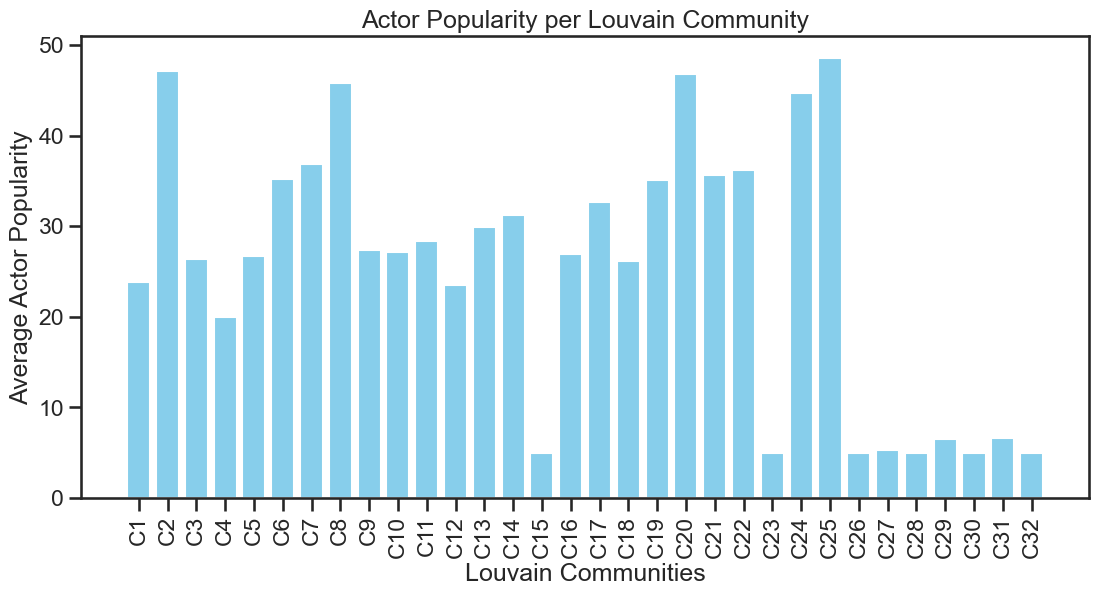

In [125]:
# Example data
data = {
    'Community': [f"C{i+1}" for i in range(len(communities))],
    'Popularity': average_popularities,
    'Sentiment': average_sentiments,
    'Profit': average_profits
}

# Convert data to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(13, 6))
plt.bar(df['Community'], df['Popularity'], color='skyblue')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Louvain Communities')
plt.ylabel('Average Actor Popularity')
plt.title('Actor Popularity per Louvain Community')
plt.show()

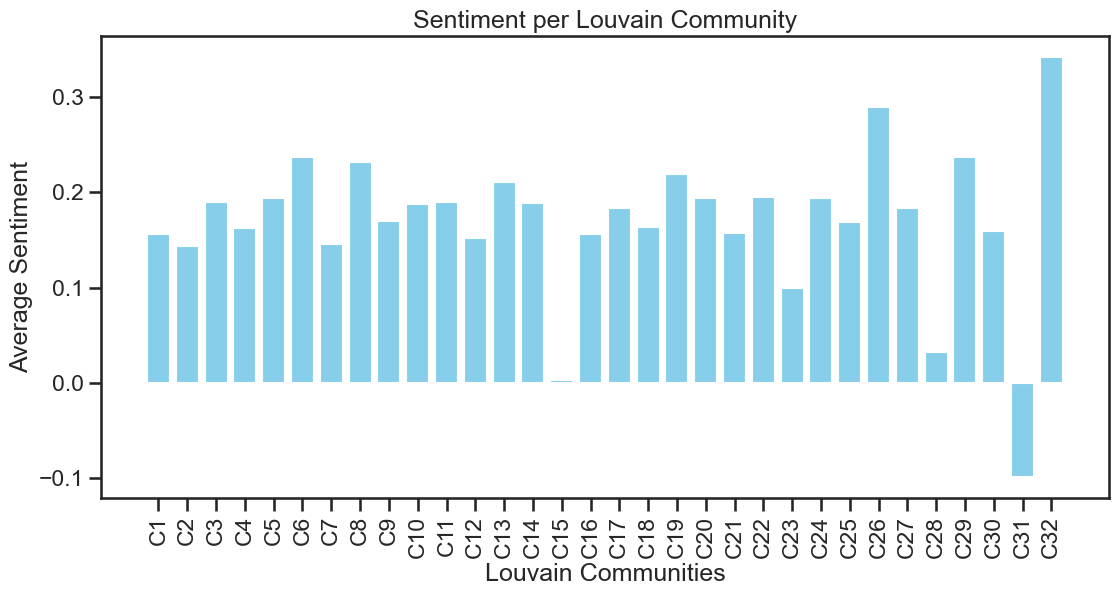

In [126]:
# Plot
plt.figure(figsize=(13, 6))
plt.bar(df['Community'], df['Sentiment'], color='skyblue')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Louvain Communities')
plt.ylabel('Average Sentiment')
plt.title('Sentiment per Louvain Community')
plt.show()

Text(0.5, 1.0, 'Profit per Louvain Community')

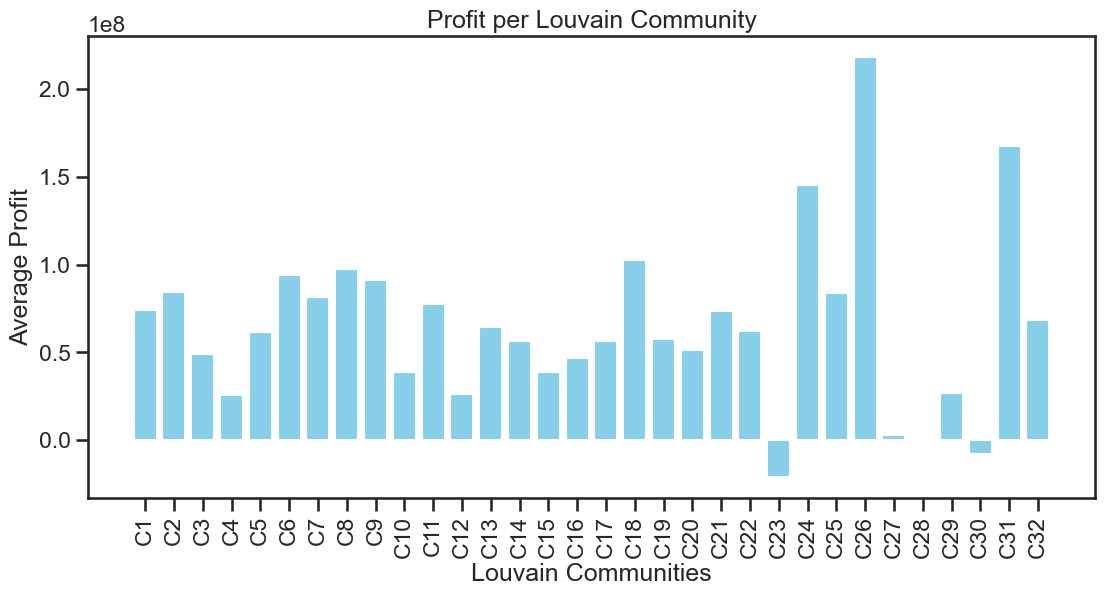

In [127]:
# Plot
plt.figure(figsize=(13, 6))
plt.bar(df['Community'], df['Profit'], color='skyblue')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Louvain Communities')
plt.ylabel('Average Profit')
plt.title('Profit per Louvain Community')

#### Sentiment Analysis in Louvain communities

In [128]:
# Group by Community and compute the variance of sentiment for communities
df.var(ddof=0, numeric_only=True).loc["Sentiment"]

0.005993514125246535

The low variance that we observe indicates consistent audience sentiment between communities.

Our next goal is to identify whether highly connected communities (which in our case means that are communities with more popular actors) show higher sentiment.

In [129]:
# Compute average degree for each community

average_degrees = {}
for index in range(len(communities)):
    community = communities[index]
    average_degrees[df.loc[index]["Community"]] = np.sum([d for movie, d in community.degree()]) / len(community)

df["Average Degree"] = average_degrees.values()

In [130]:
# Test if there is statistically significant correlation between the degree of a community and its average sentiment

# Calculate the Pearson correlation coefficient and p-value
corr, p_value = stats.pearsonr(df['Average Degree'], df['Sentiment'])

# Print results
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")

# Check if p-value is less than significance level (e.g., 0.05)
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

spearman_corr, spearman_p = stats.spearmanr(df['Average Degree'], df['Sentiment'])
# Print results
print(f"\n\nSpearman correlation coefficient: {spearman_corr}")
print(f"P-value: {spearman_p}")

# Check if p-value is less than significance level (e.g., 0.05)
if spearman_p < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Pearson correlation coefficient: 0.2033093532788082
P-value: 0.2644051932900758
The correlation is not statistically significant.


Spearman correlation coefficient: 0.1803815535146702
P-value: 0.32318712271037886
The correlation is not statistically significant.
